In [1]:
from os.path import join, dirname, exists
from os import makedirs
from itertools import chain, islice

from thesis_v2 import dir_dict

In [2]:
from scipy.stats import sem
import numpy as np

In [3]:
import pandas as pd

In [4]:
f_main_result = join(dir_dict['analyses'], 'yuanyuan_8k_a_3day_refactored', '20200725+20200801+20200801_2', 'hal_tuning_complete.pkl')
df_main_result = pd.read_pickle(f_main_result)

In [5]:
df_main_result

hal_tuning_analysis  \
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep                       
relu     False                mse       0          2         8           1           cm-avg       1280                      None   
                                                                                                  2560                      None   
                                                                                                  5120                      None   
                                                                                     cm-last      1280                      None   
                                                                                                  2560                      None   
...                                                                                                                          ...   
softplus True                 poisson   1          6         16          1           legacy       2560                      None   
                                                                                                  5120                      None   
                                                             32          1           legacy       1280                      None   
                                                                                                  2560                      None   
                                                                                                  5120                      None   

                                                                                                             hal_tuning_analysis_half_improved  \
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep                                     
relu     False                mse       0          2         8           1           cm-avg       1280                                    None   
                                                                                                  2560                                    None   
                                                                                                  5120                                    None   
                                                                                     cm-last      1280                                    None   
                                                                                                  2560                                    None   
...                                                                                                                                        ...   
softplus True                 poisson   1          6         16          1           legacy       2560                                    None   
                                                                                                  5120                                    None   
                                                             32          1           legacy       1280                                    None   
                                                                                                  2560                                    None   
                                                                                                  5120                                    None   

                                                                                                             hal_tuning_analysis_half_improved_baseline  \
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep                                              
relu     False                mse       0          2         8           1           cm-avg       1280                                             None   
                            

In [6]:
def get_mean(x):
    if x is None:
        return np.nan
    return x['diffs'].mean()
def get_sem(x):
    if x is None:
        return np.nan
    return sem(x['diffs'], ddof=0)


df_main_result['hal_tuning_improved_mean'] = df_main_result['hal_tuning_analysis_improved'].map(lambda x: get_mean(x))
df_main_result['hal_tuning_improved_baseline_mean'] = df_main_result['hal_tuning_analysis_improved_baseline'].map(lambda x: get_mean(x))
df_main_result['hal_tuning_half_improved_mean'] = df_main_result['hal_tuning_analysis_half_improved'].map(lambda x: get_mean(x))
df_main_result['hal_tuning_half_improved_baseline_mean'] = df_main_result['hal_tuning_analysis_half_improved_baseline'].map(lambda x: get_mean(x))

In [7]:
# show mean vs sem, for different cls

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

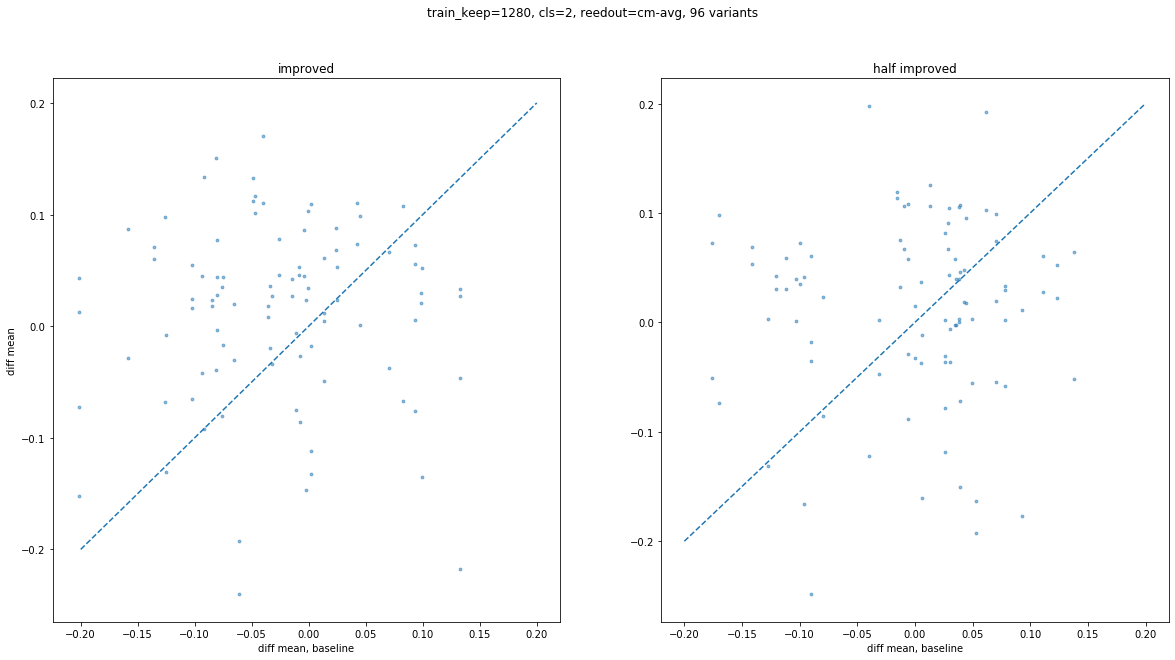

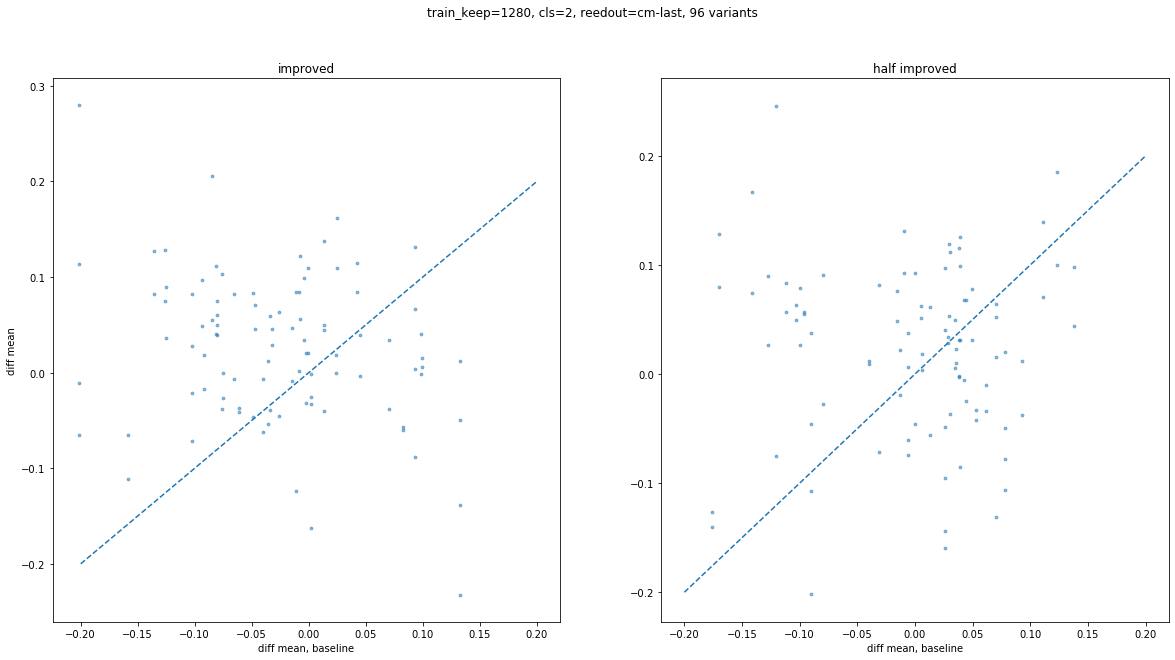

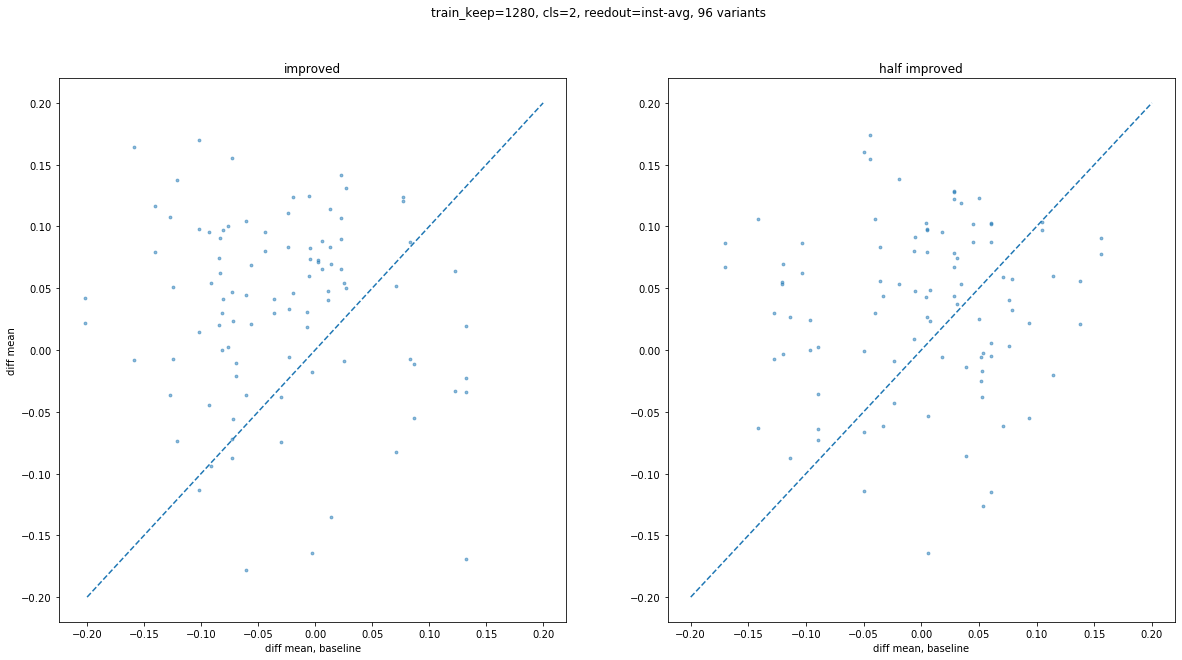

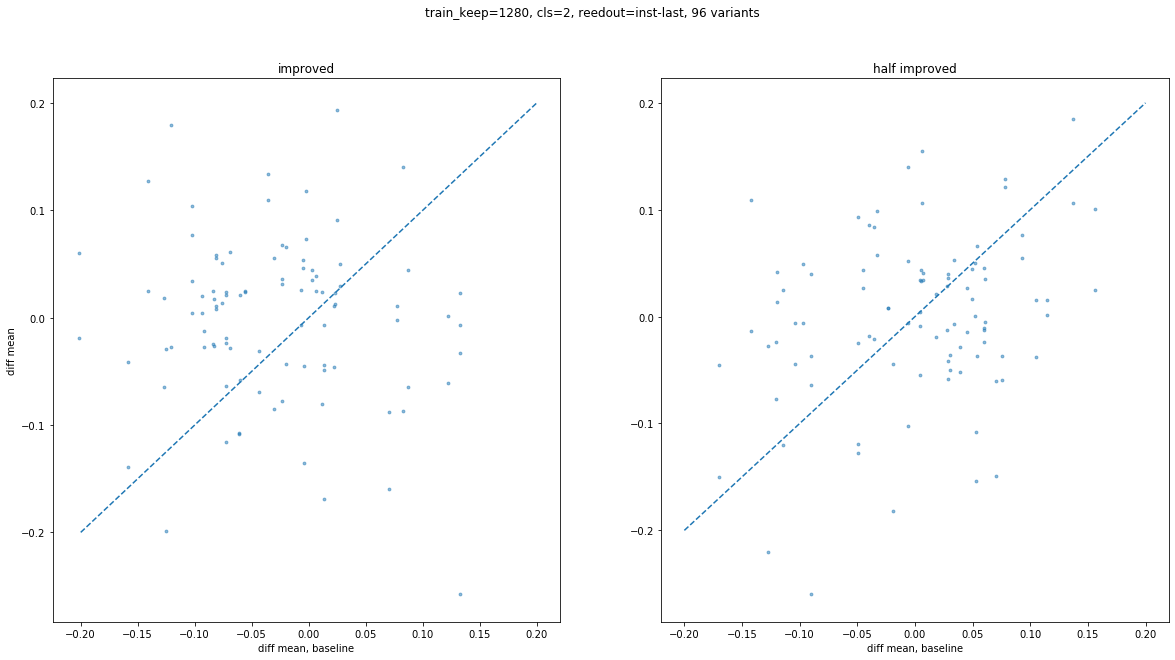

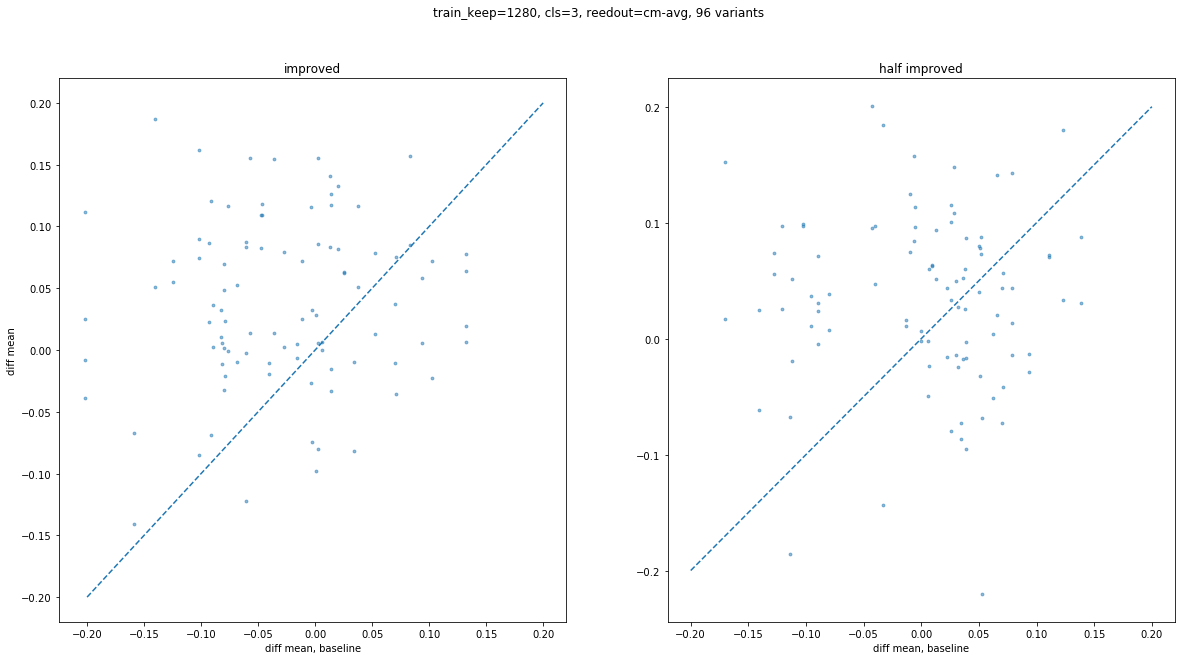

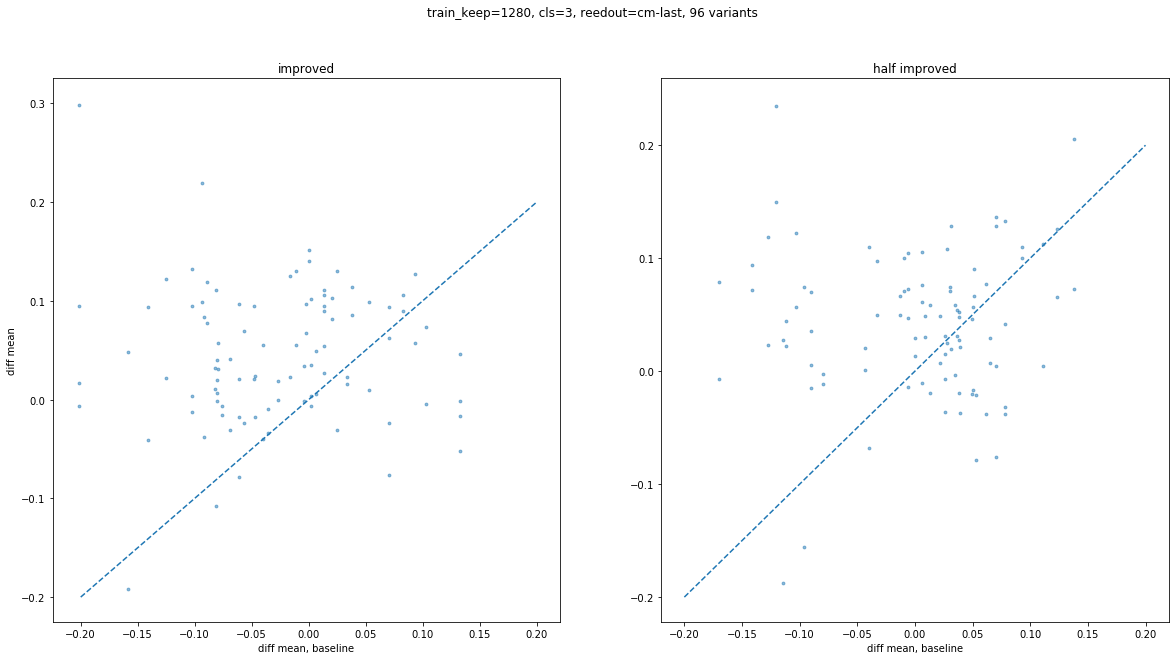

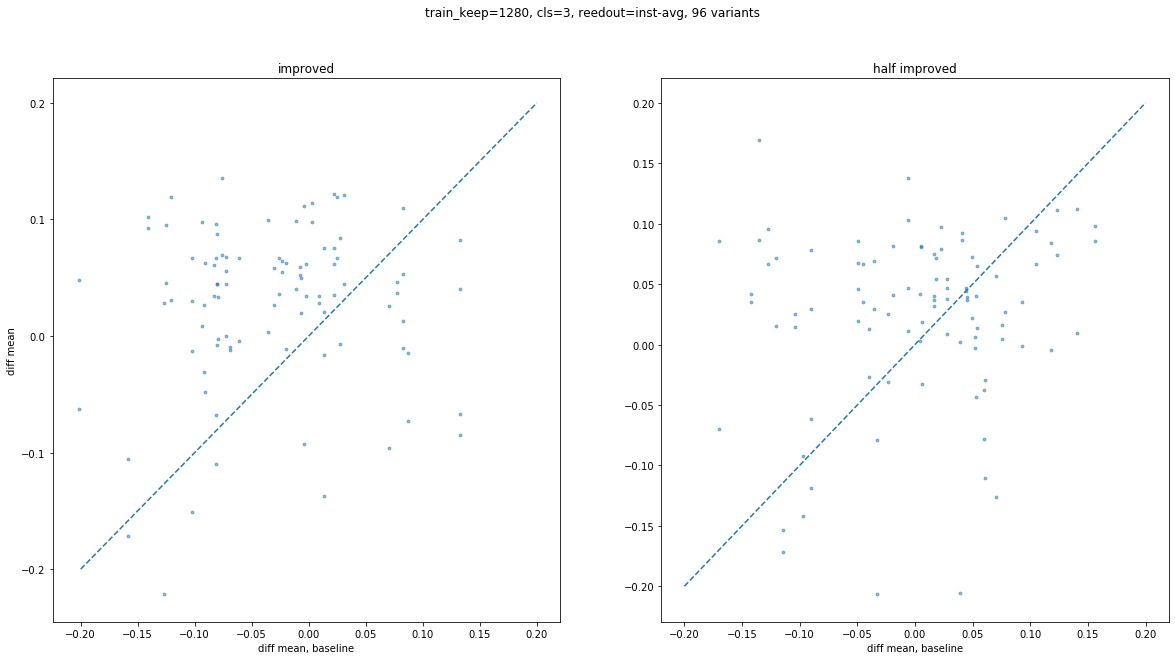

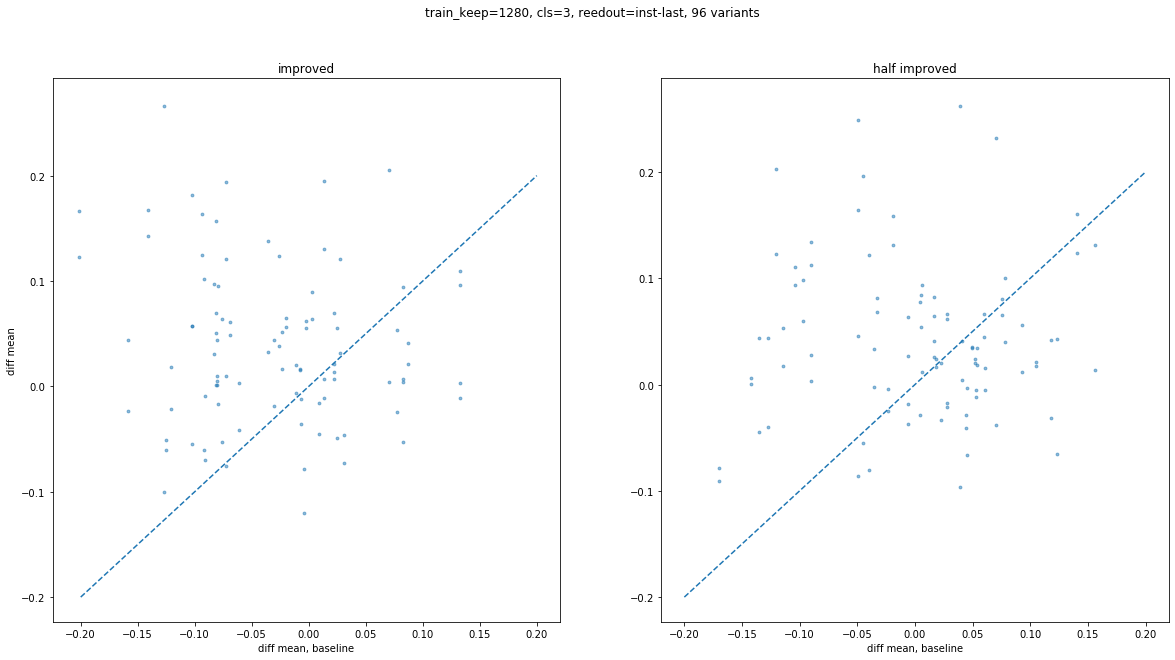

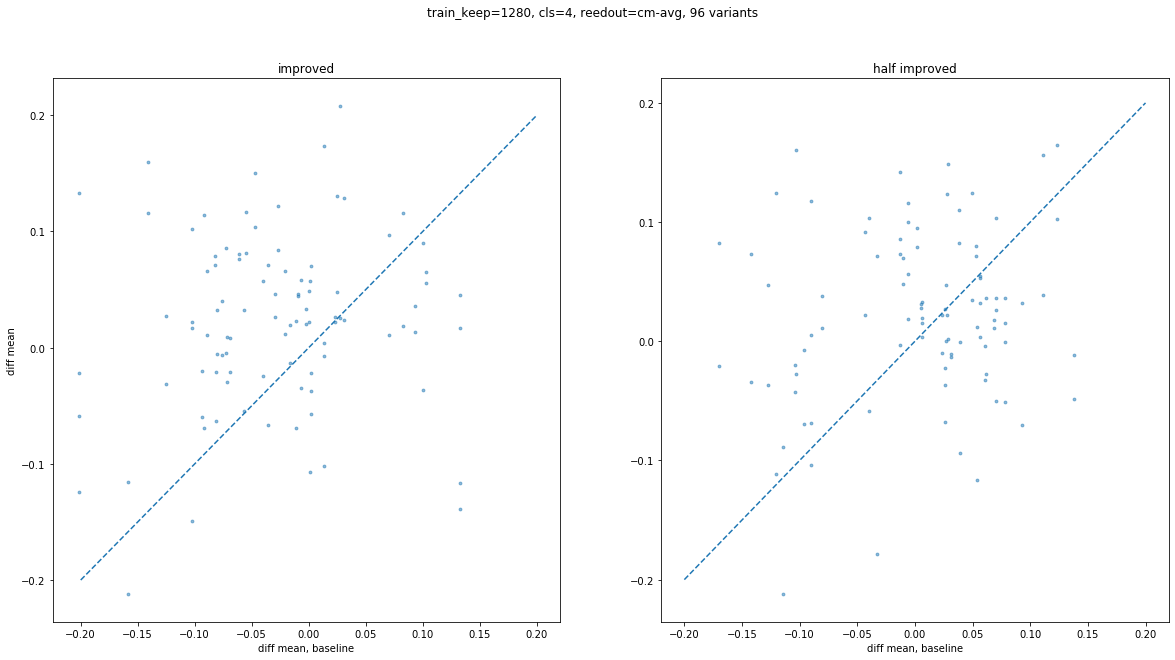

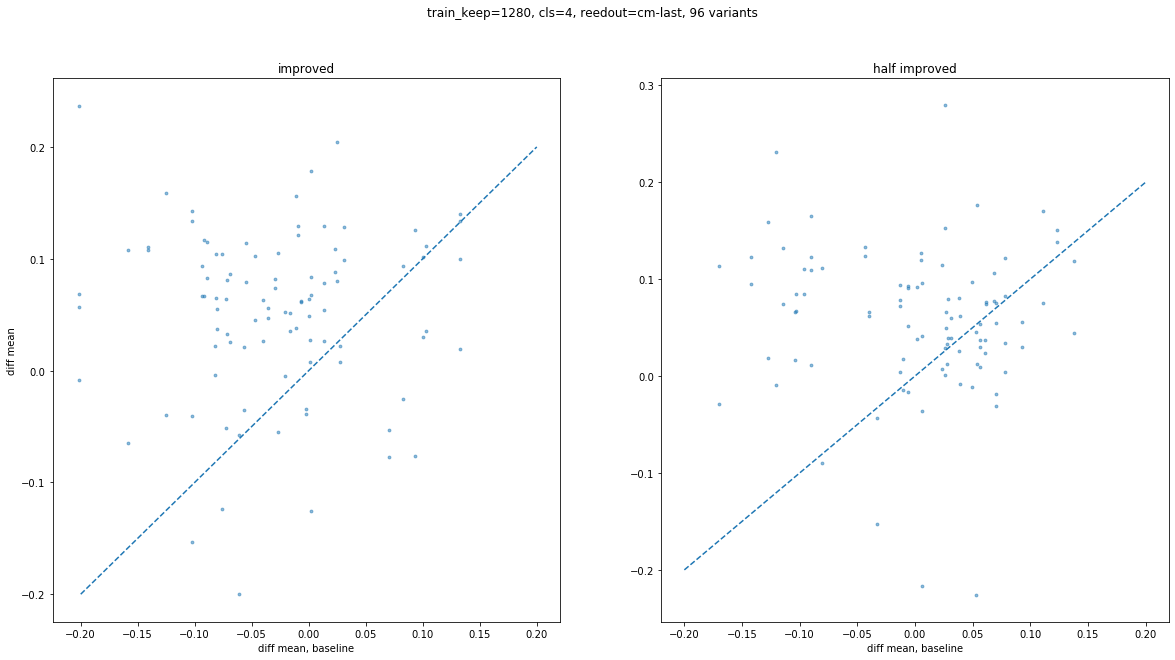

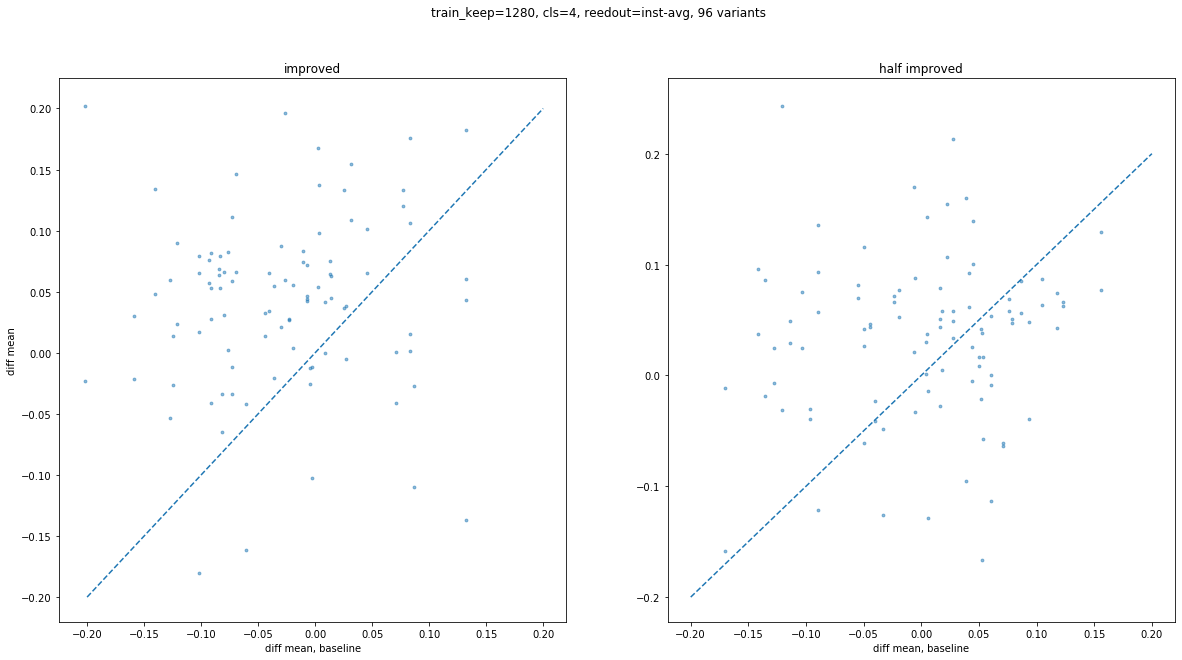

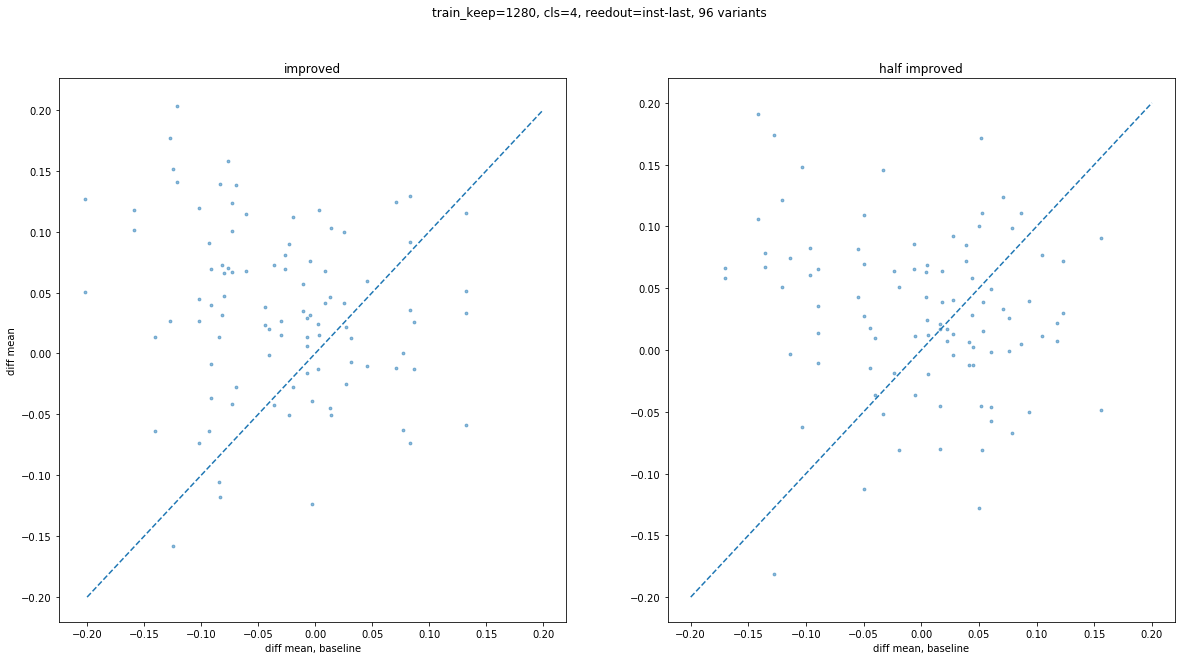

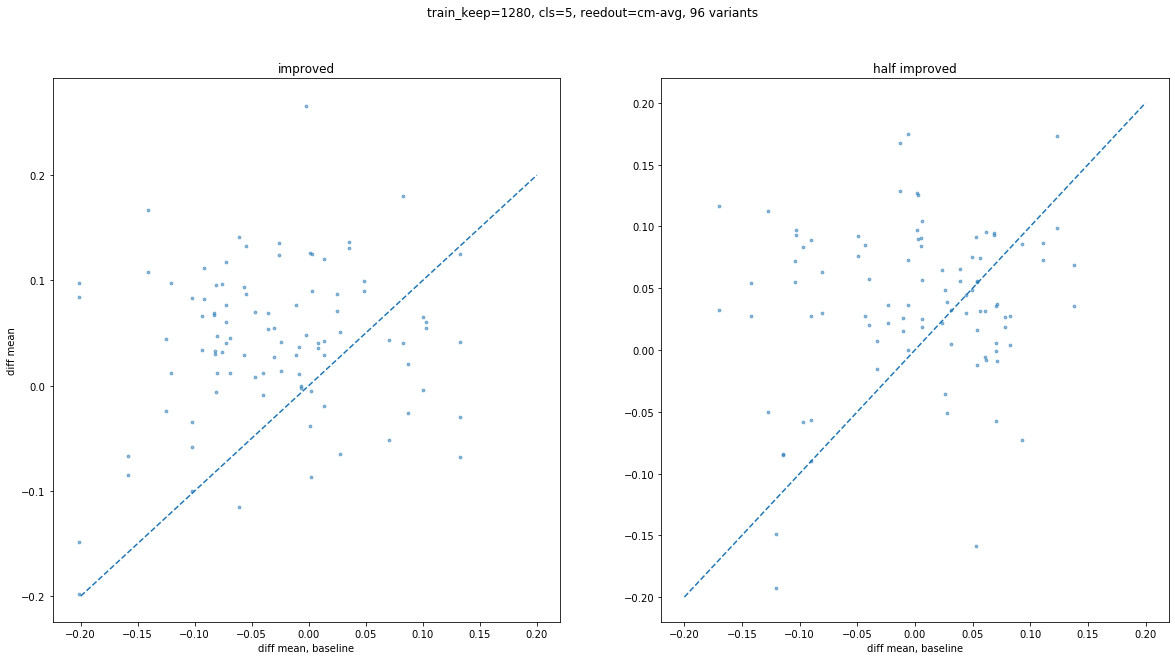

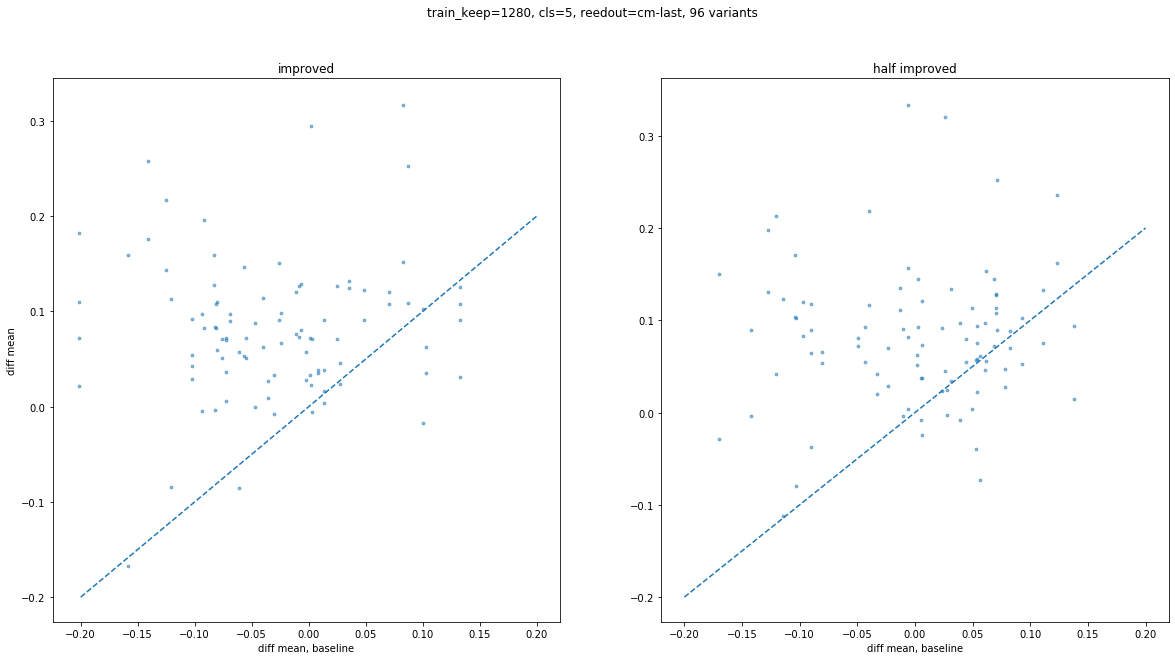

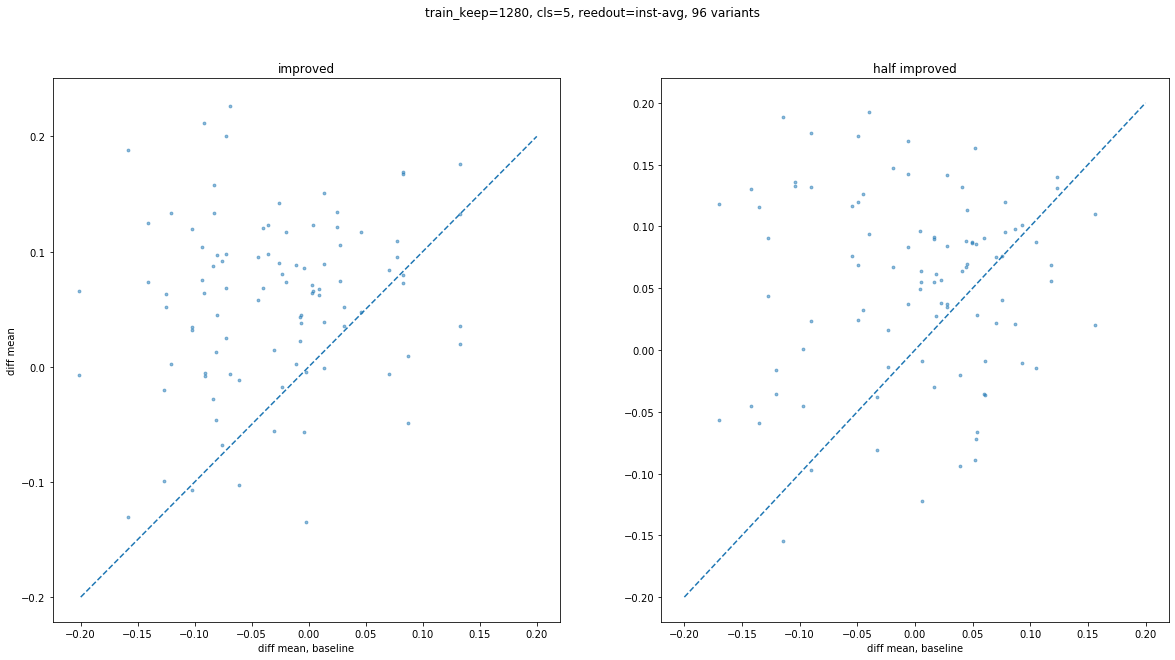

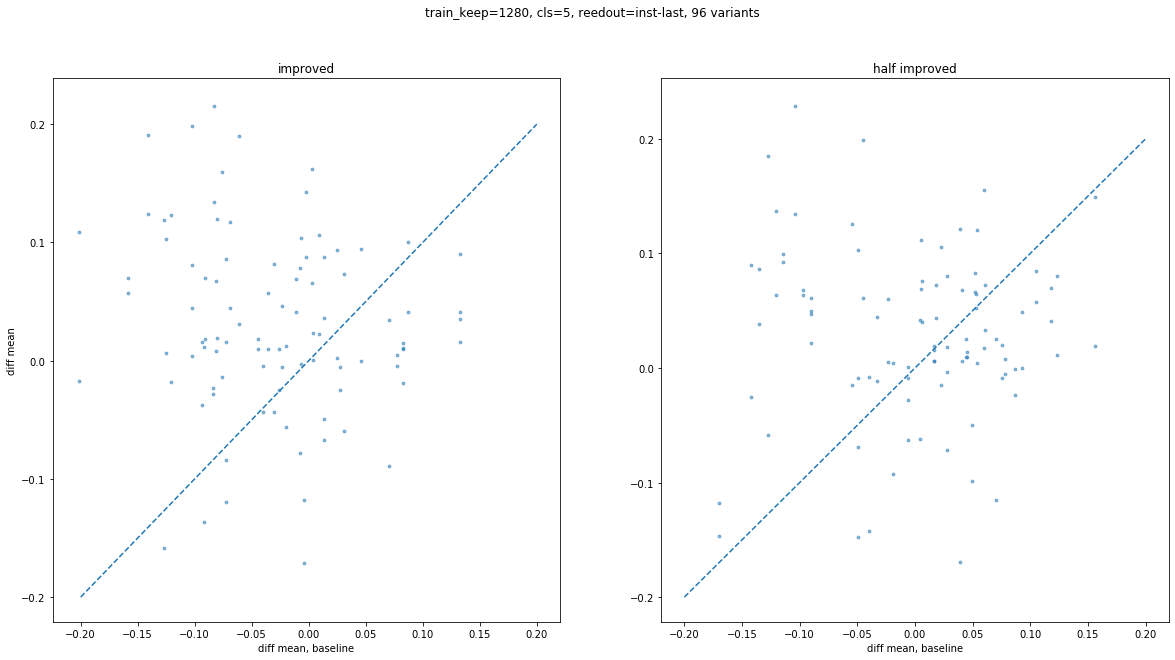

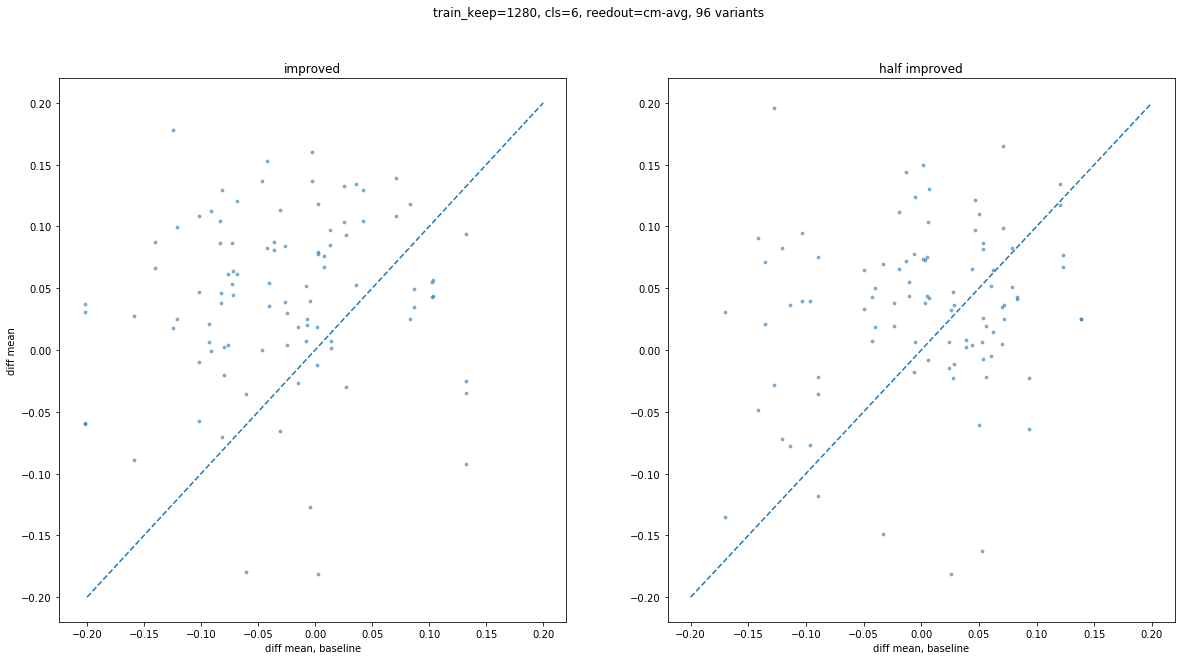

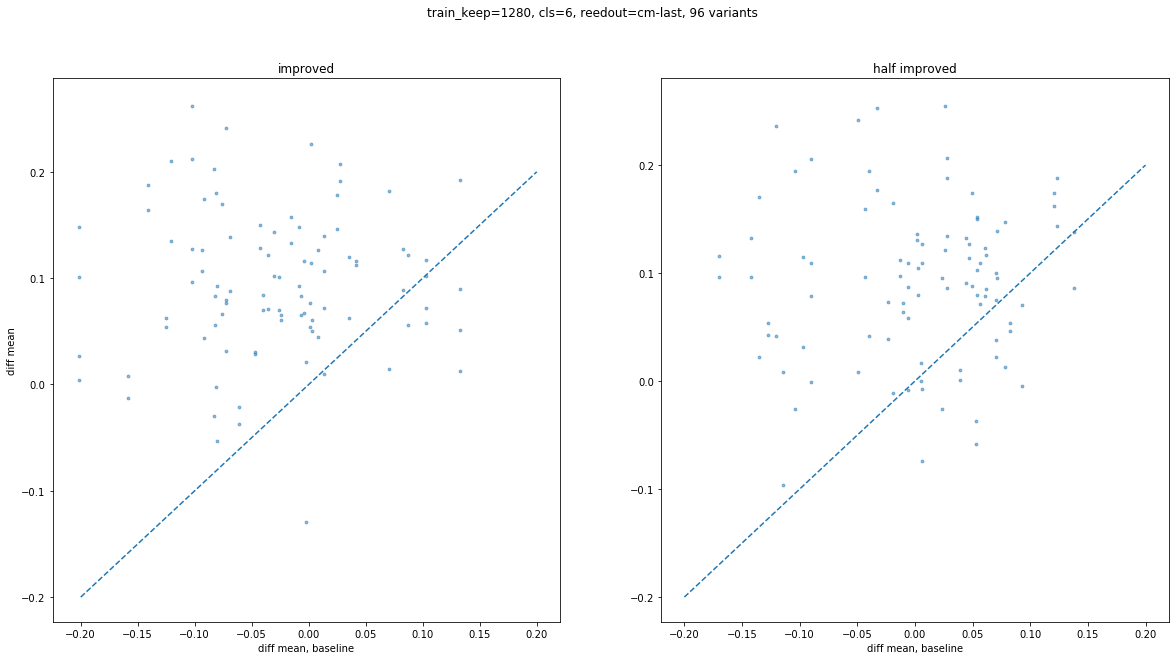

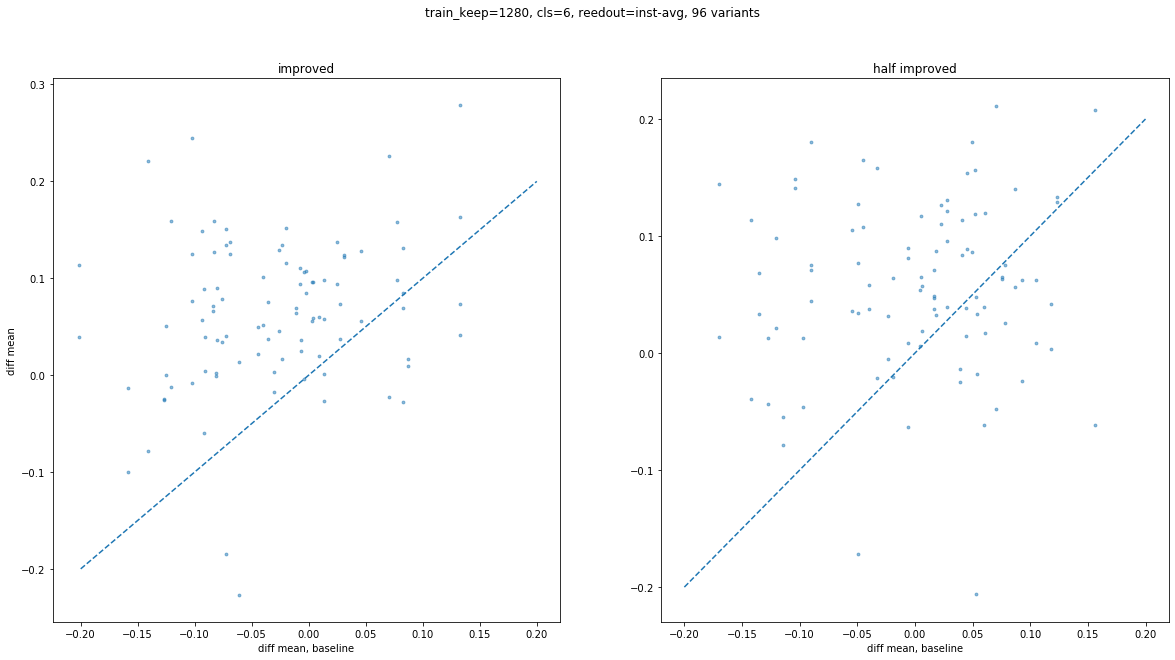

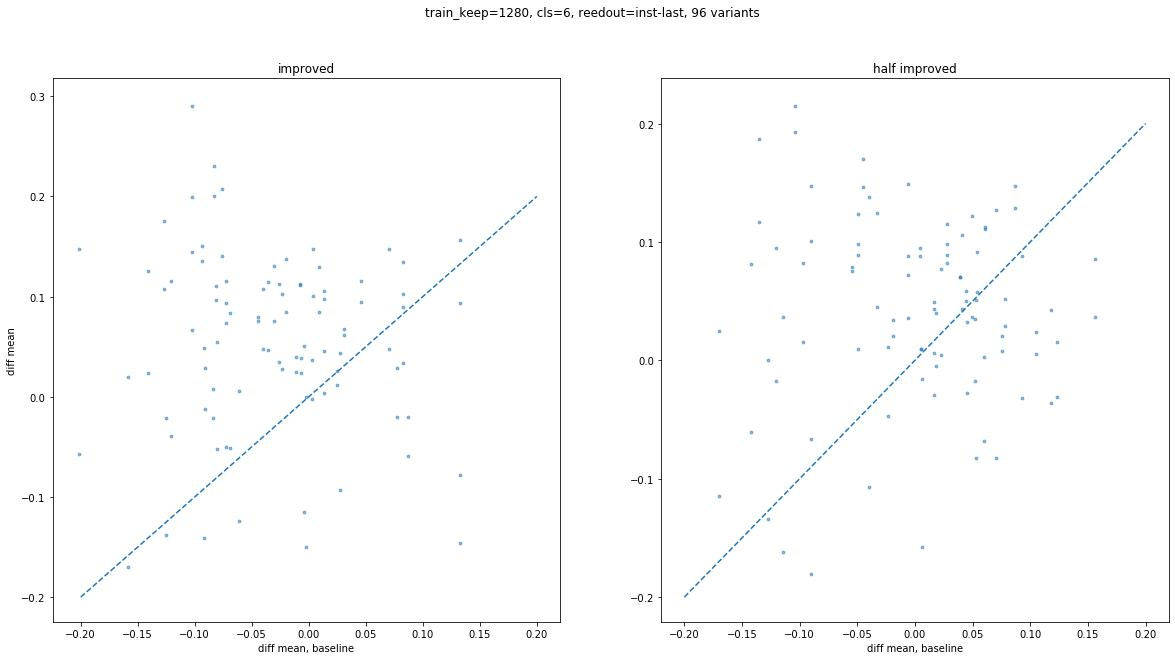

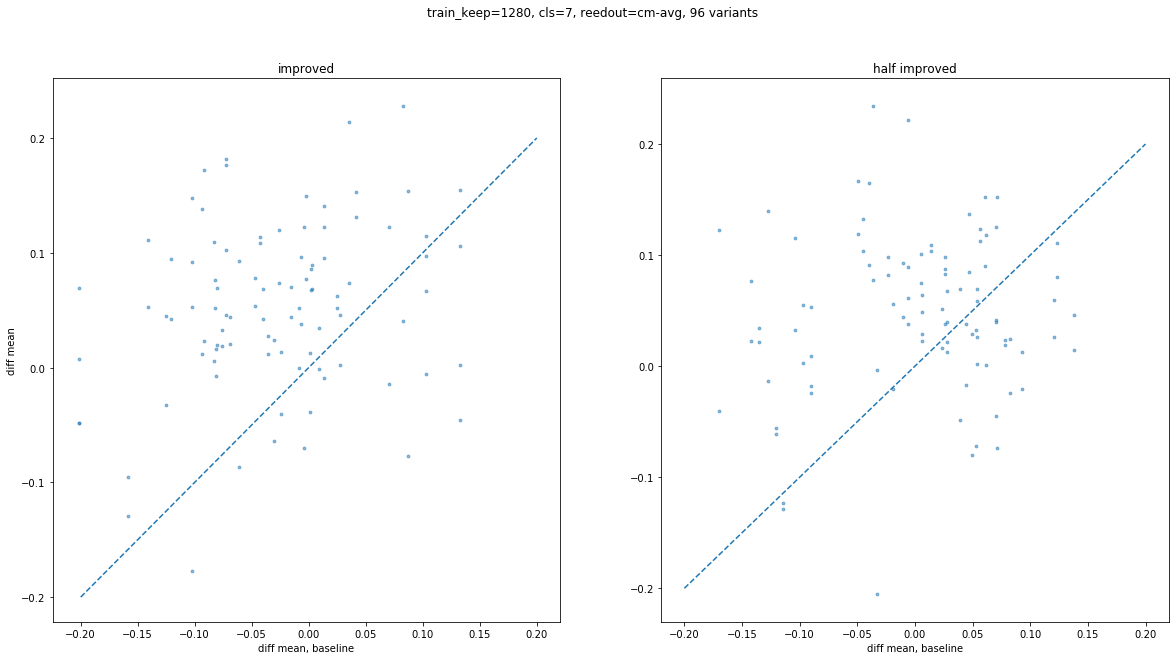

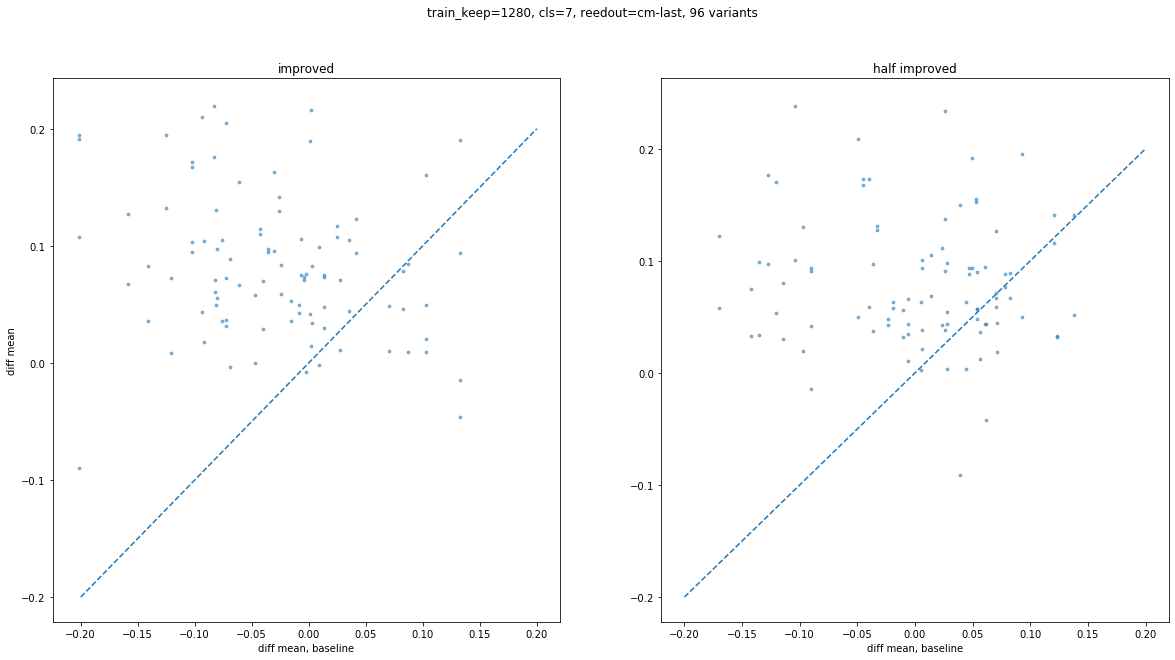

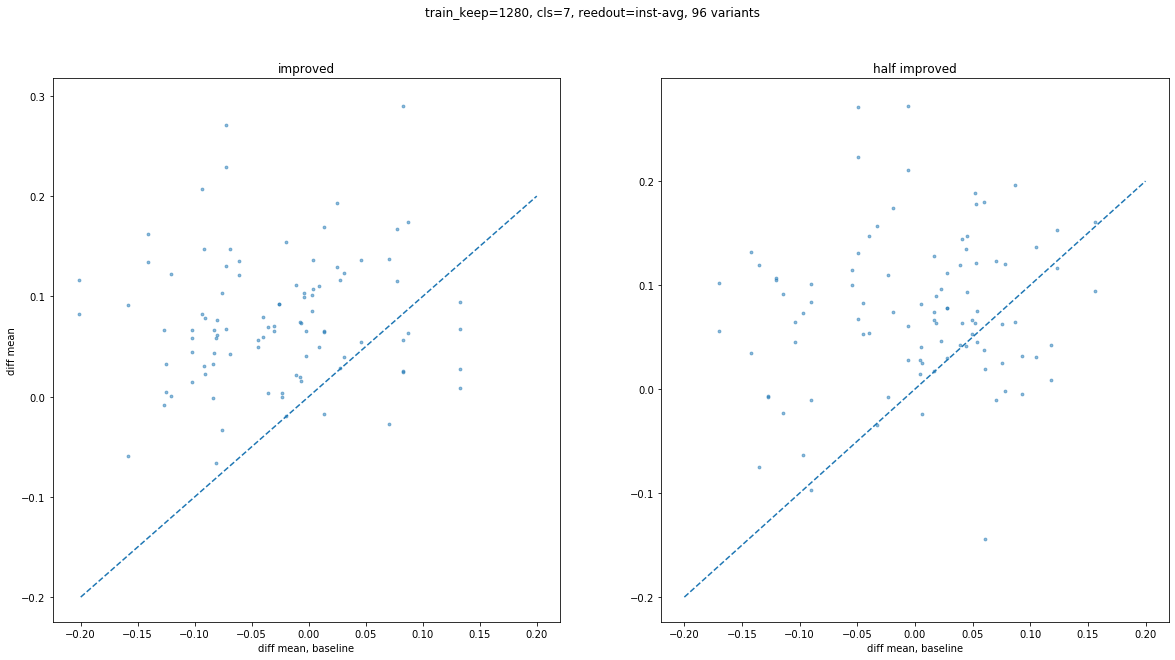

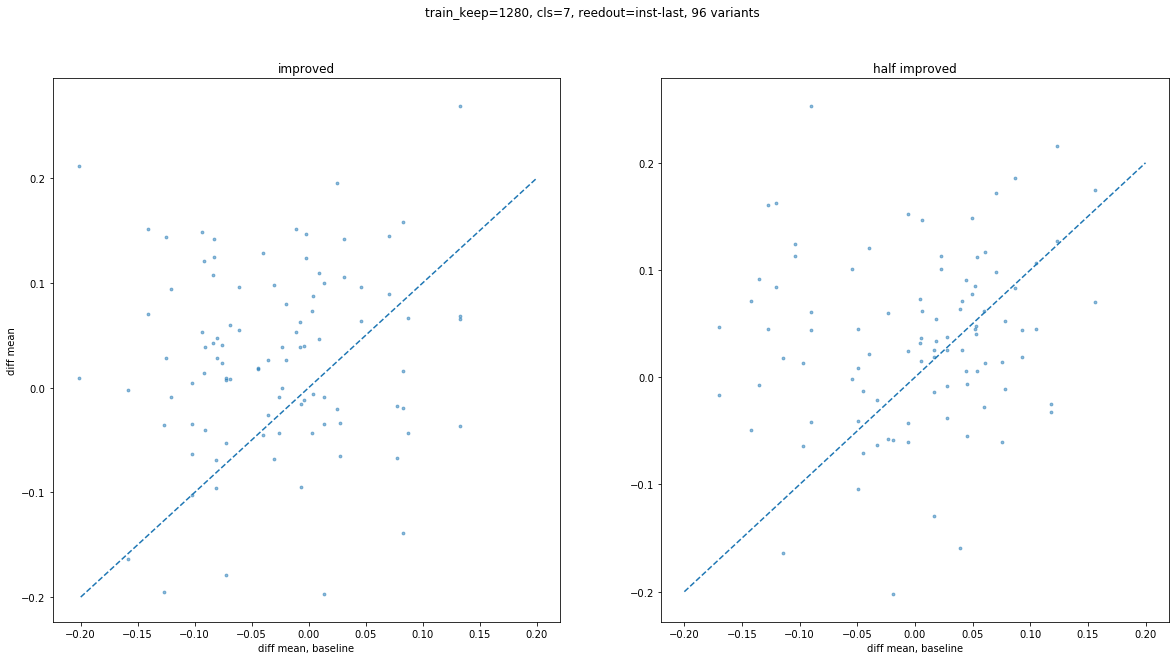

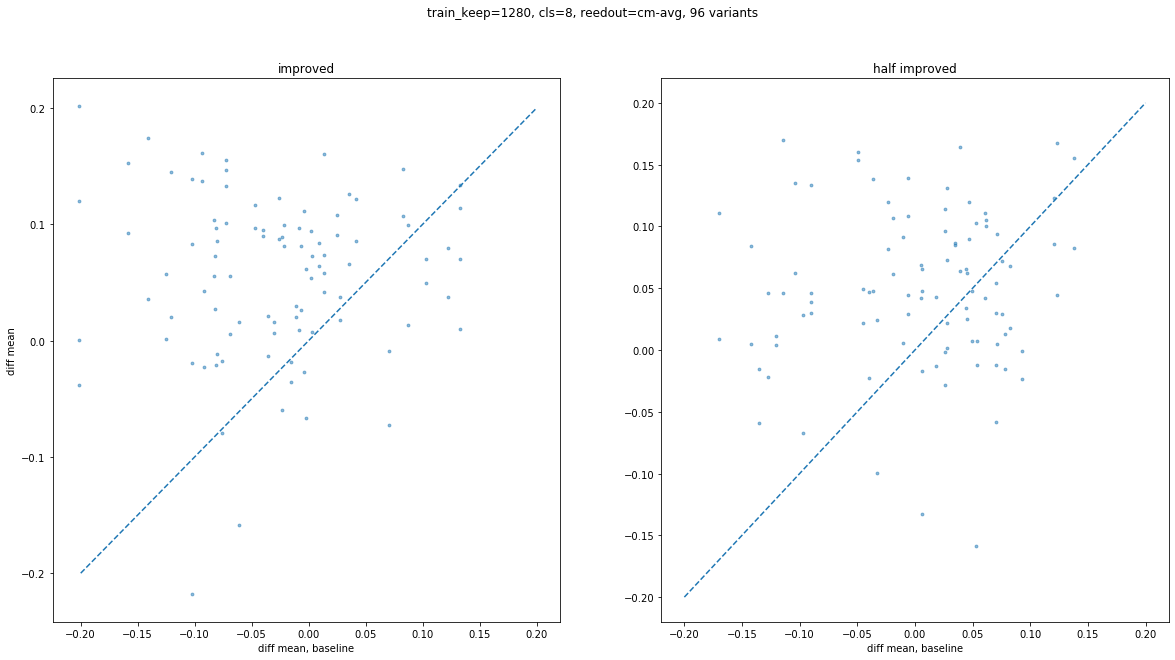

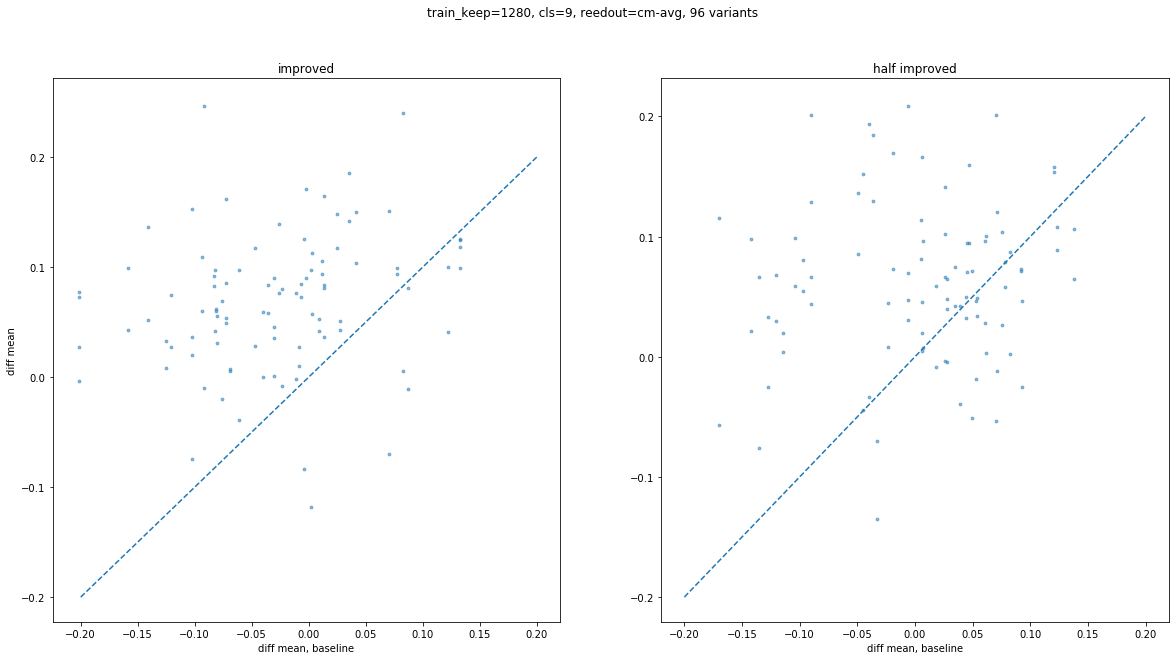

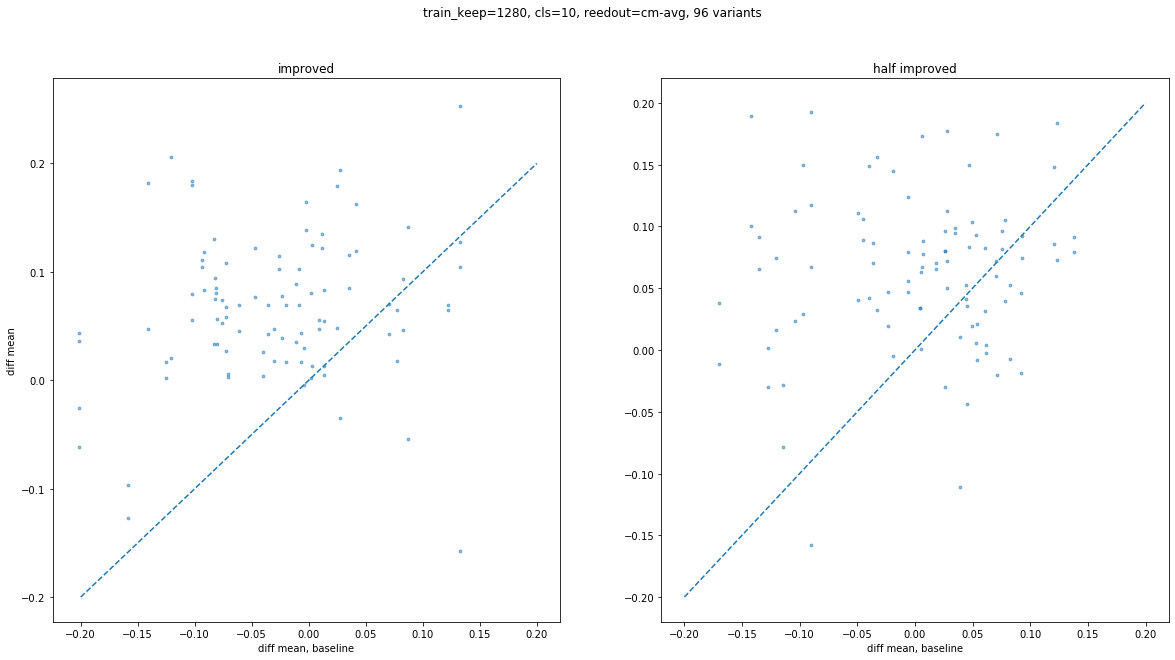

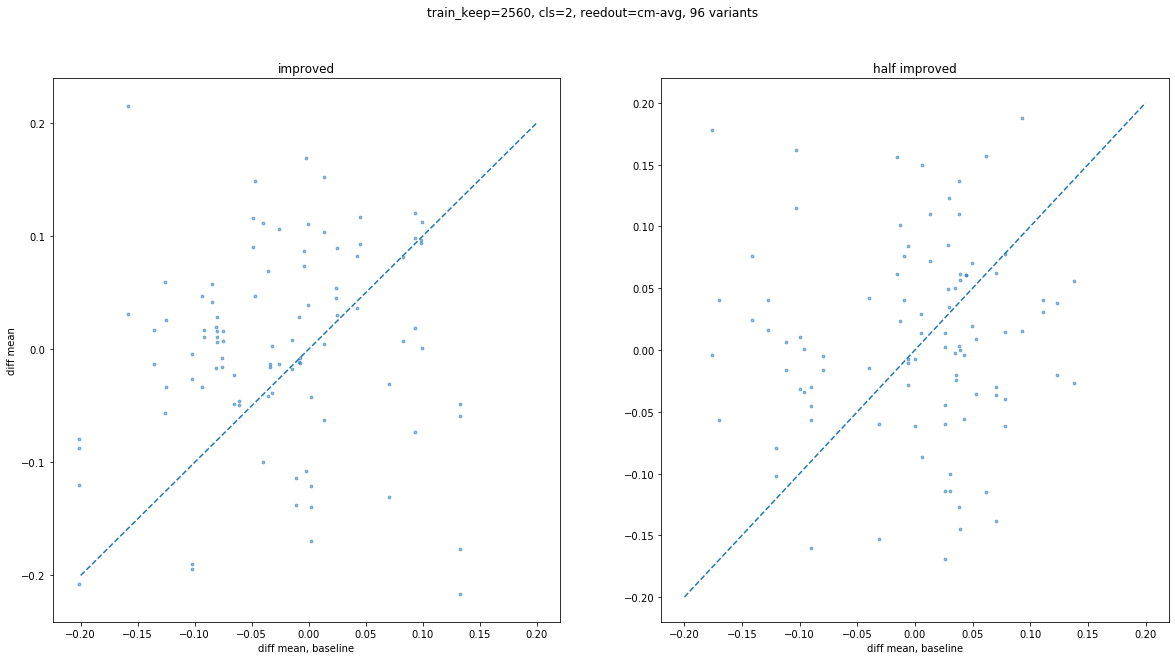

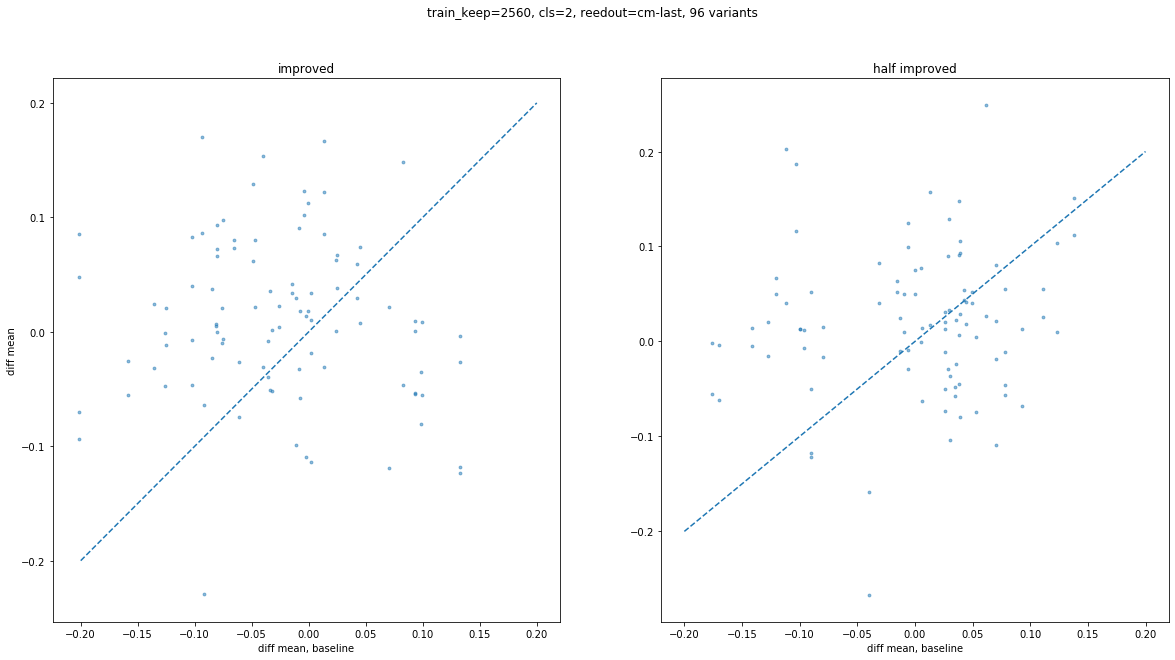

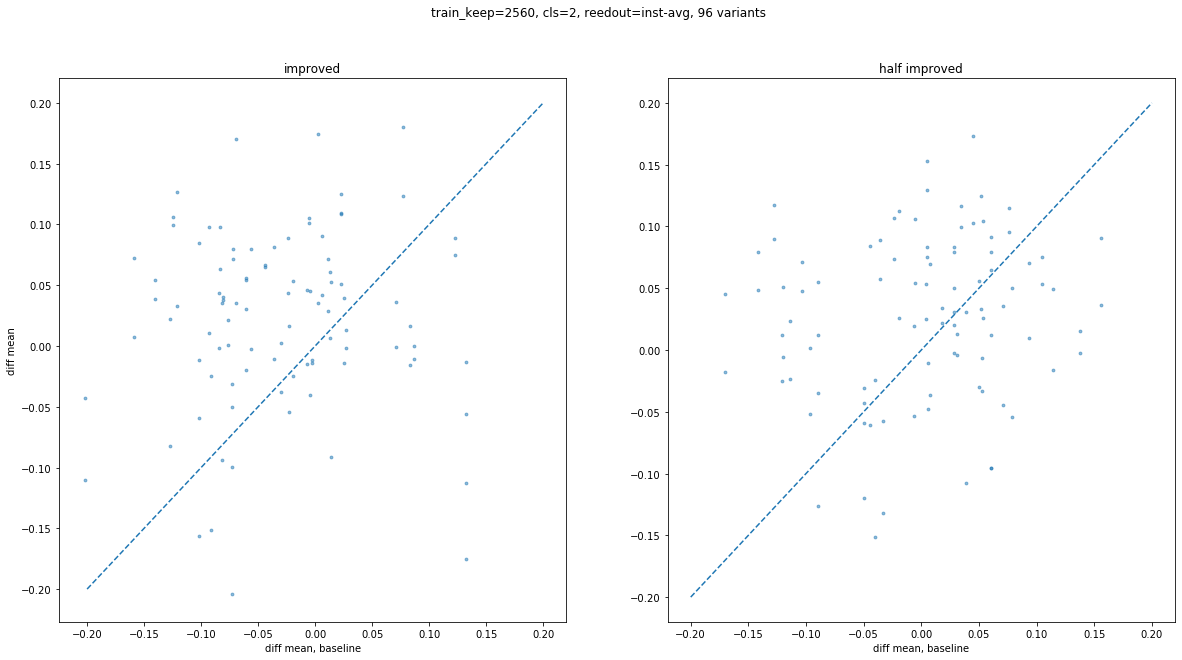

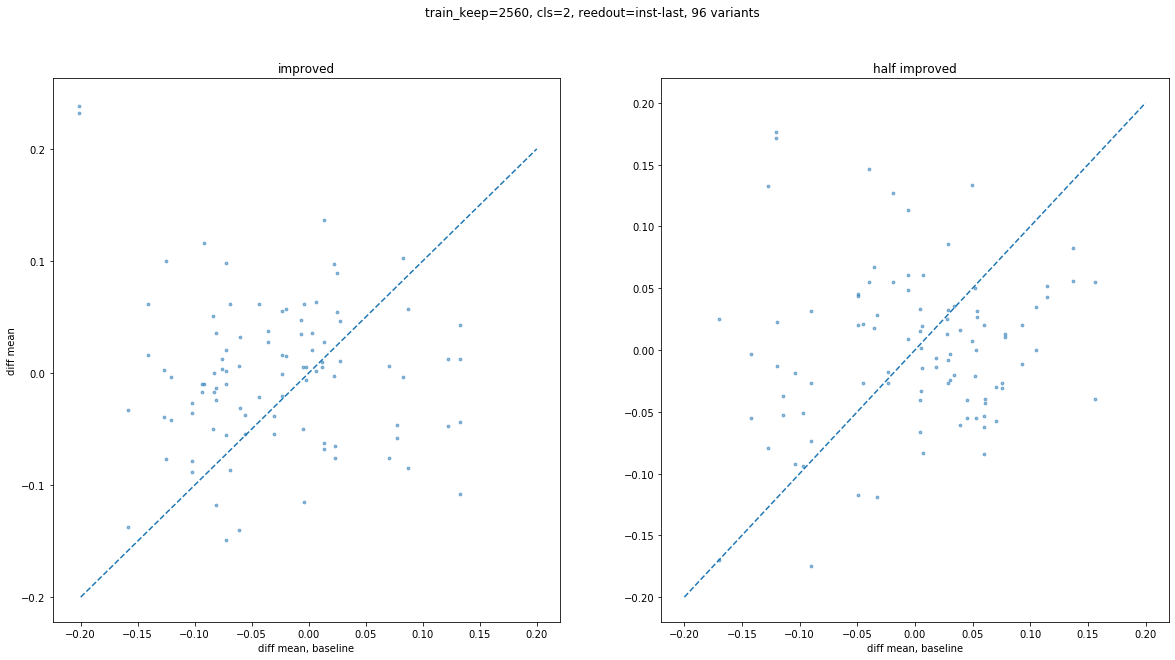

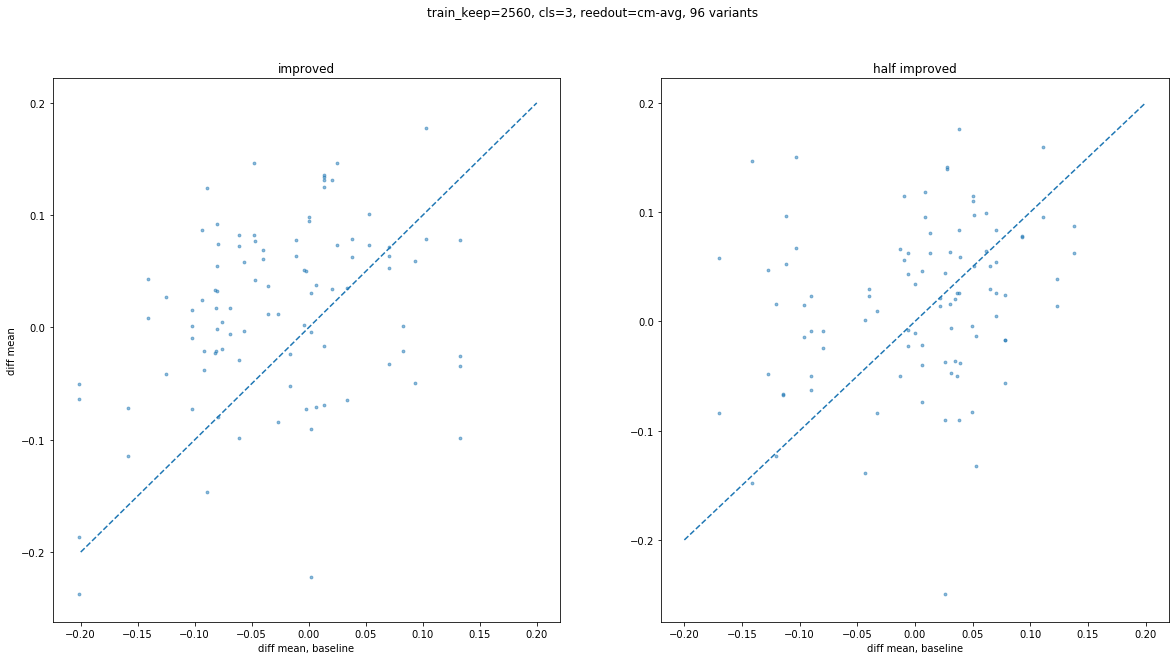

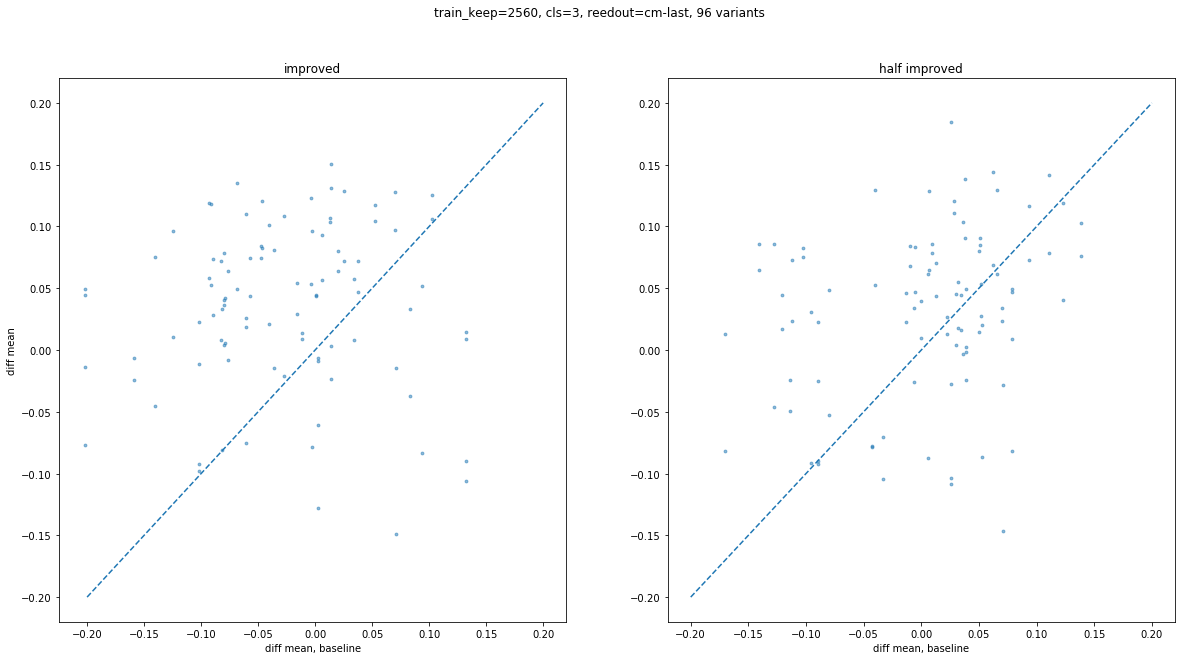

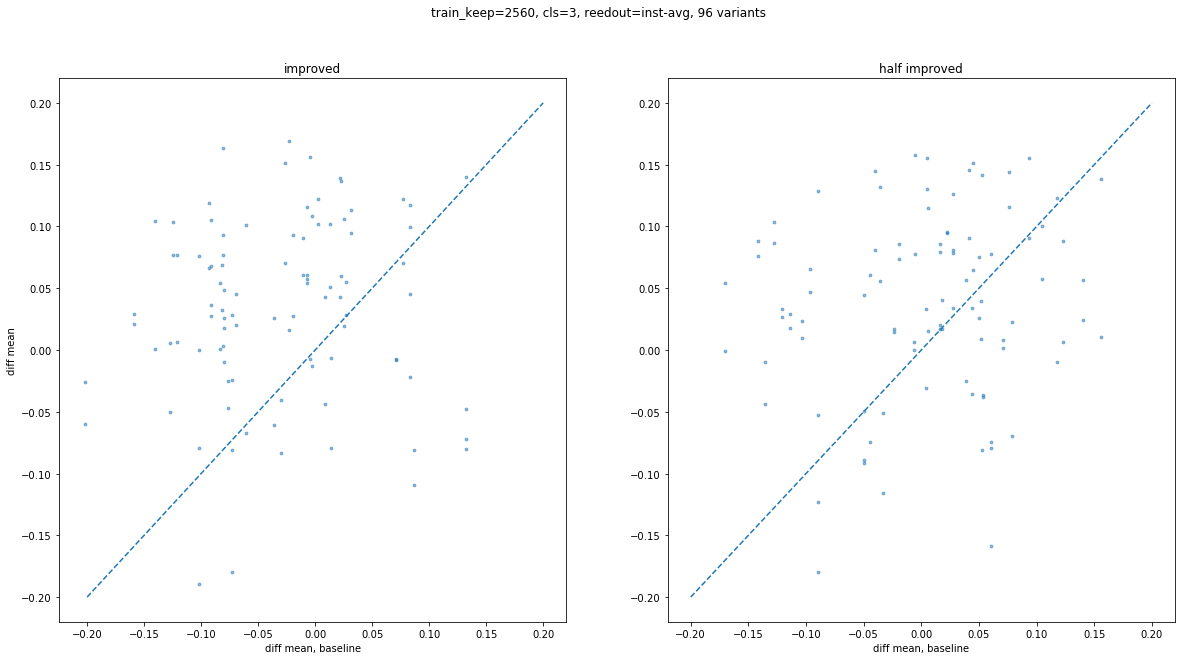

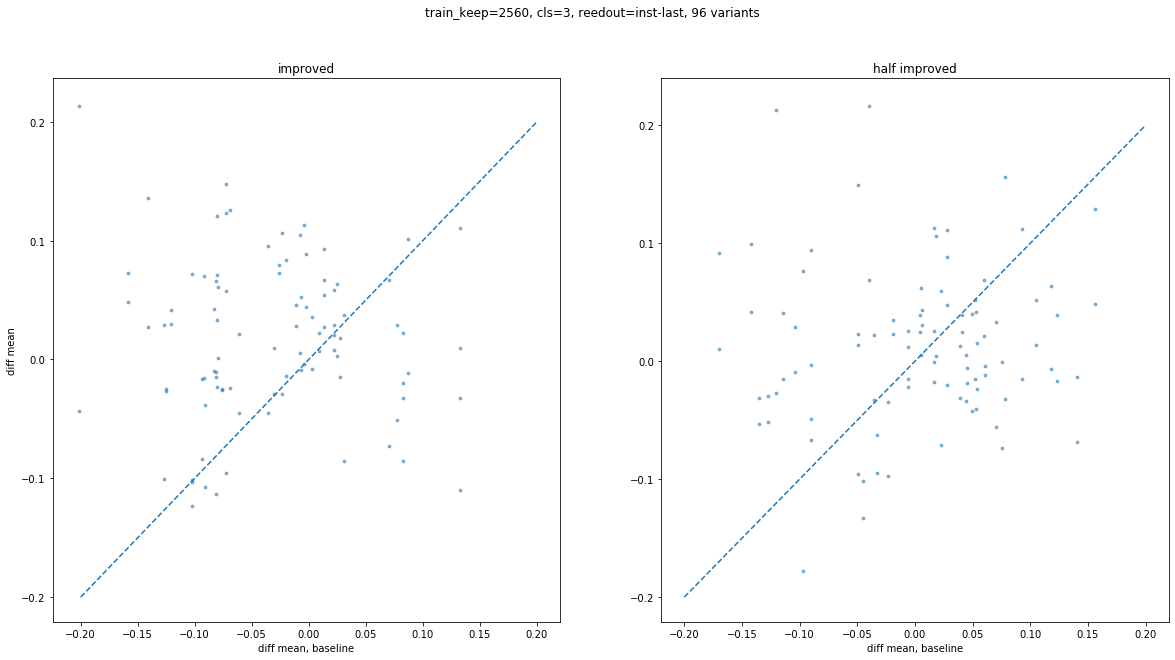

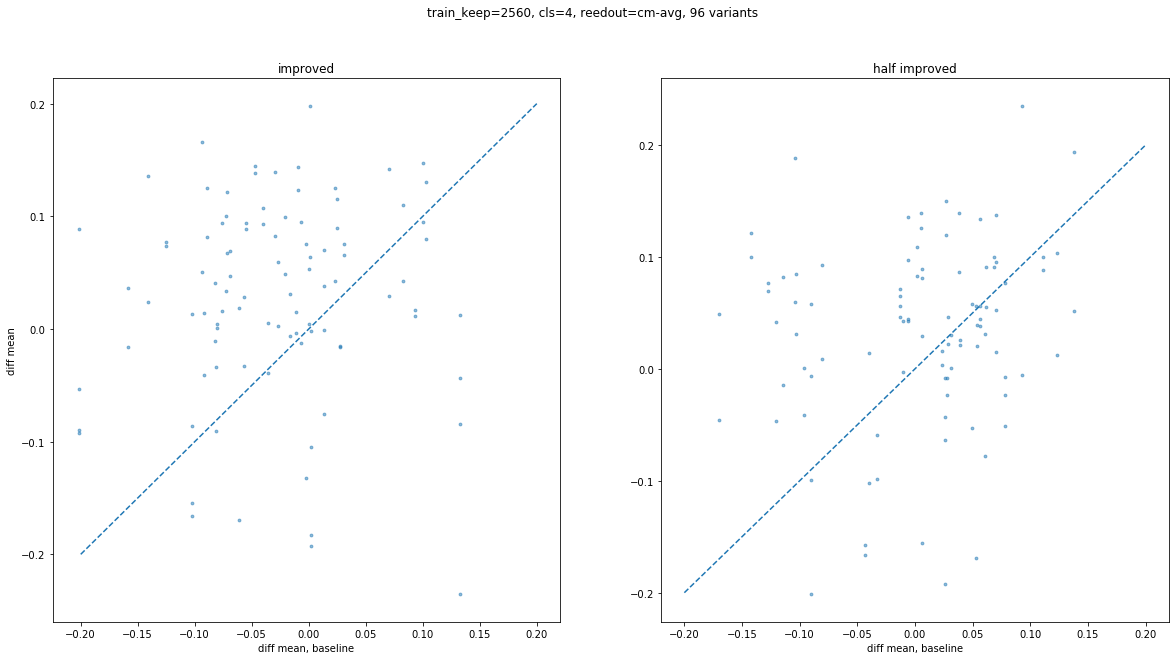

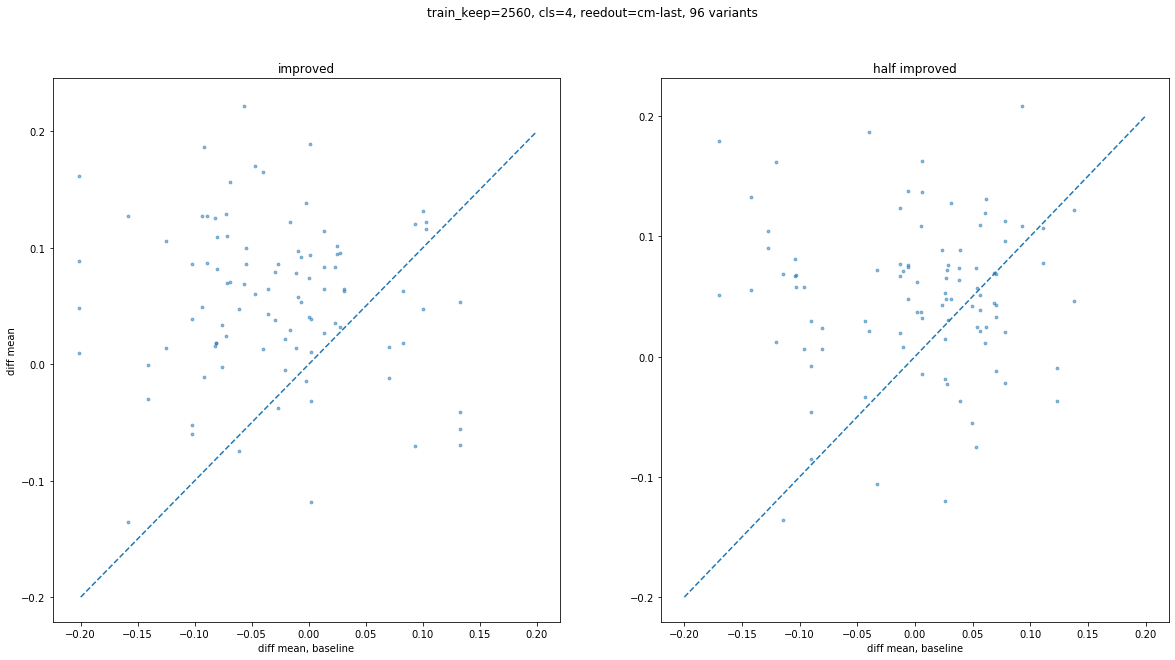

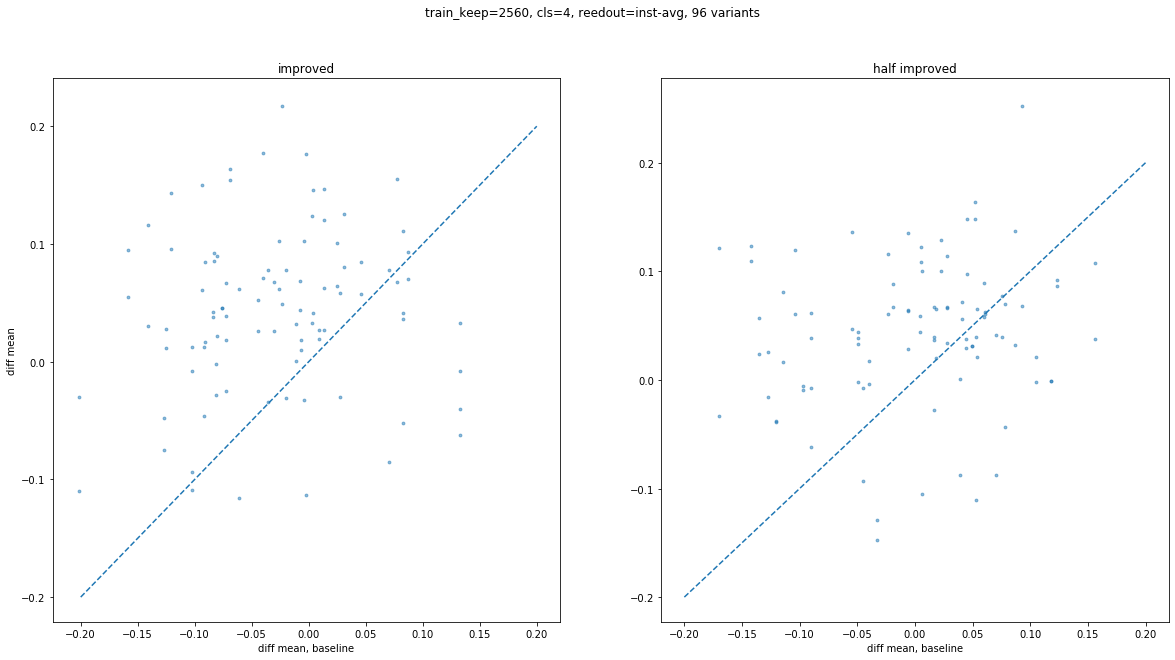

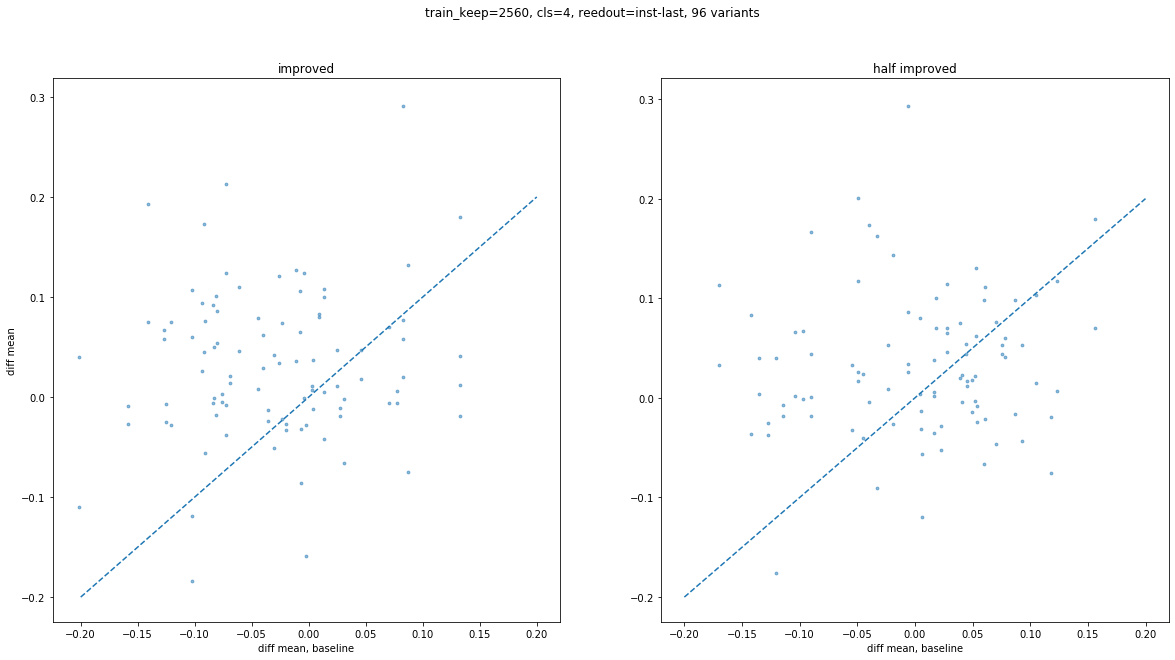

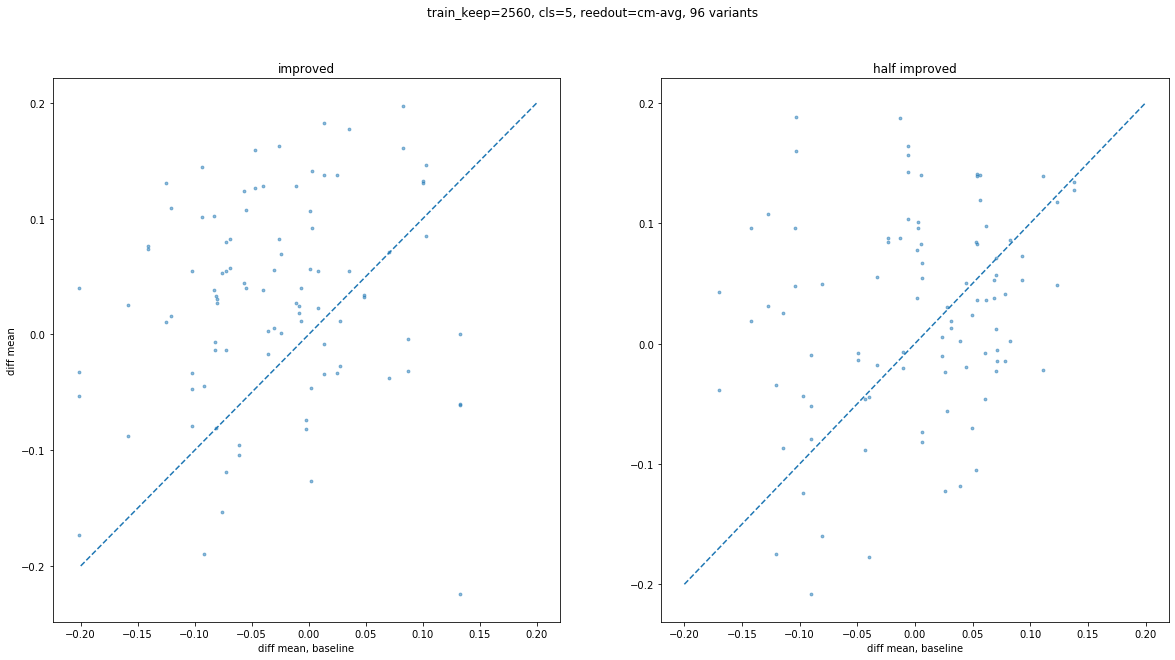

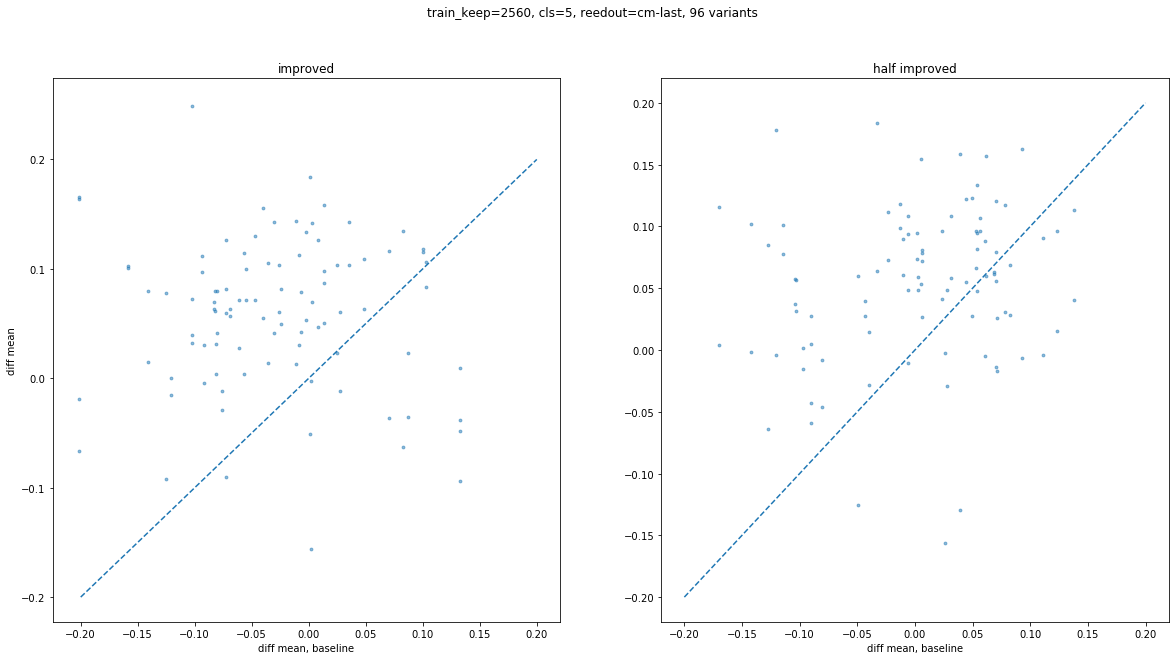

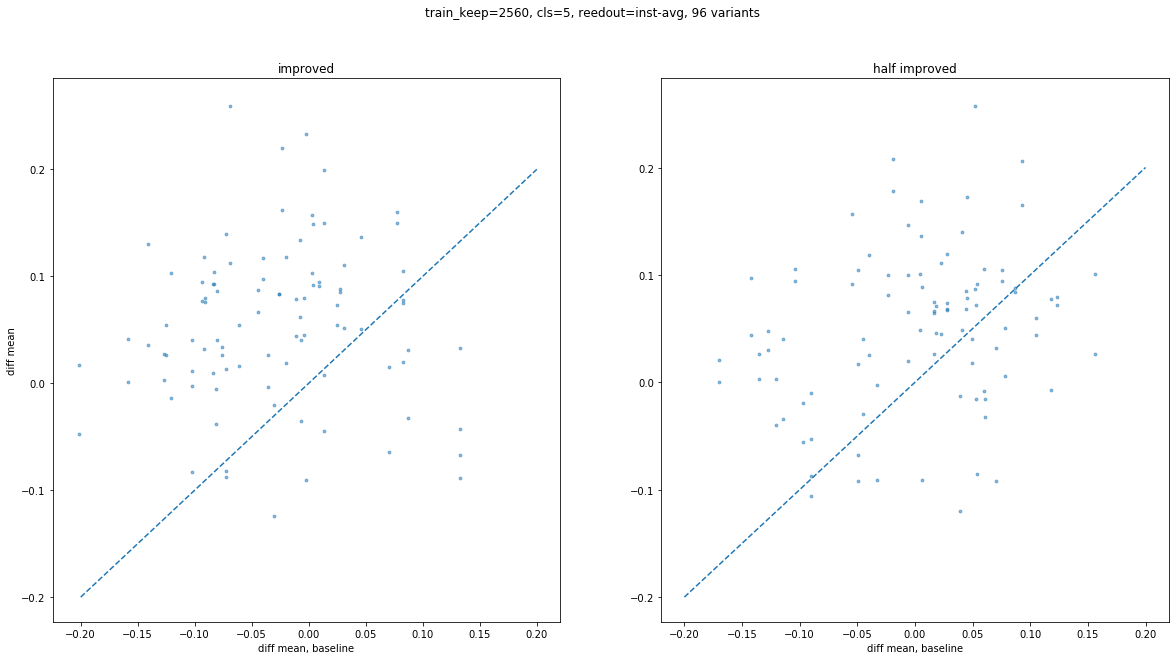

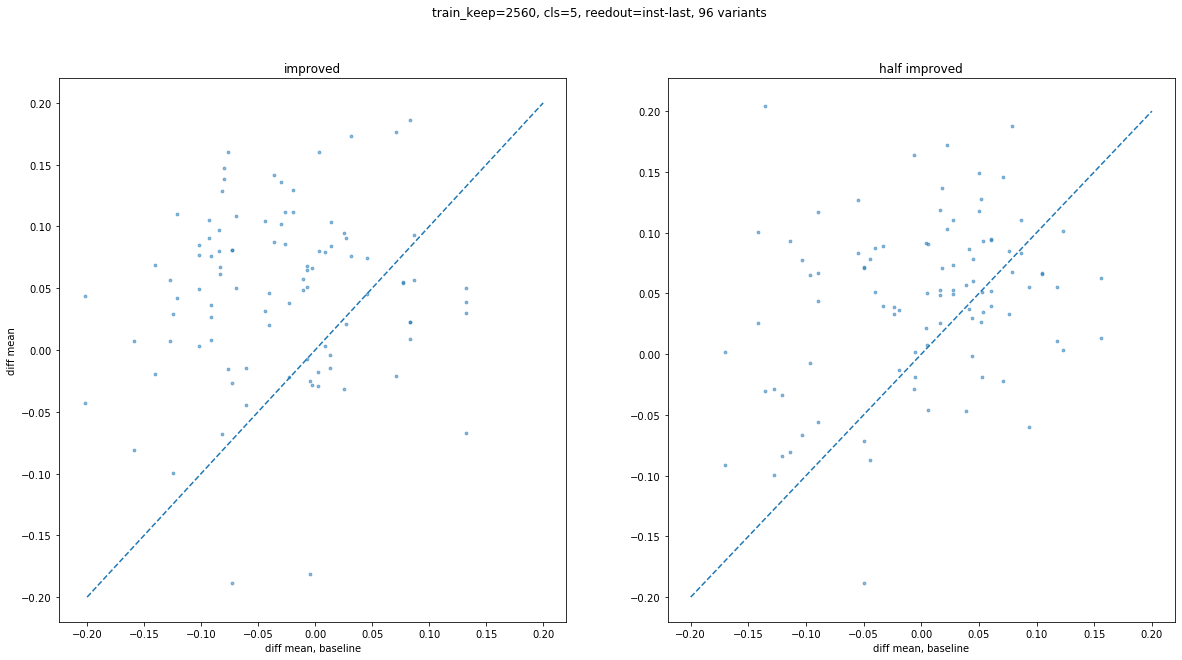

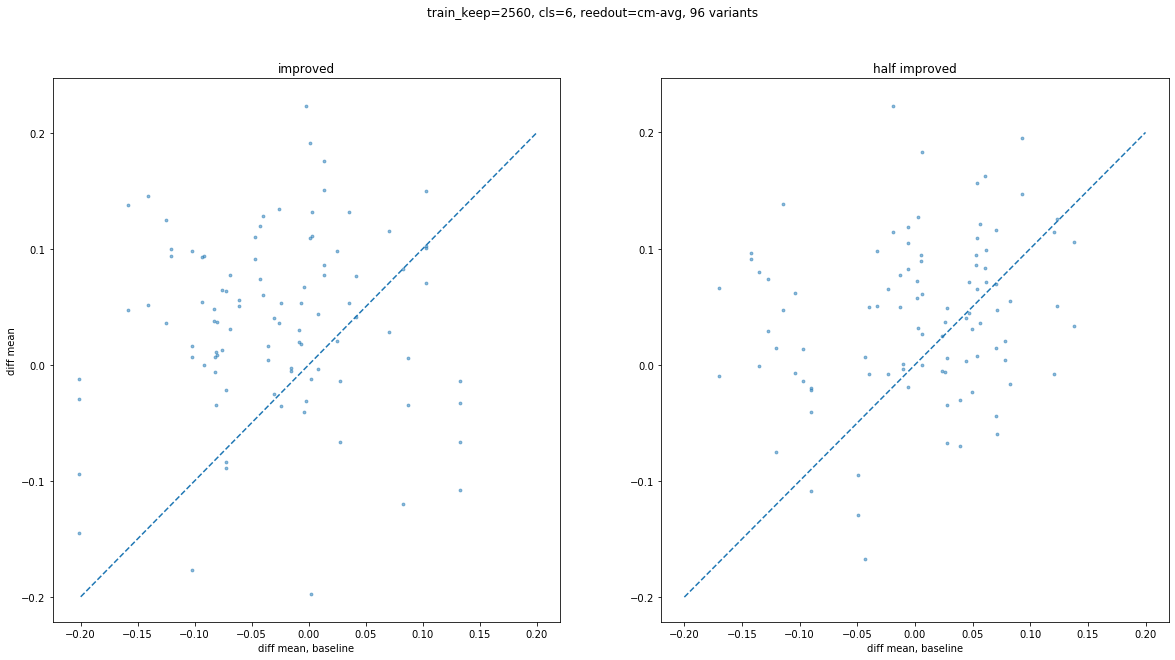

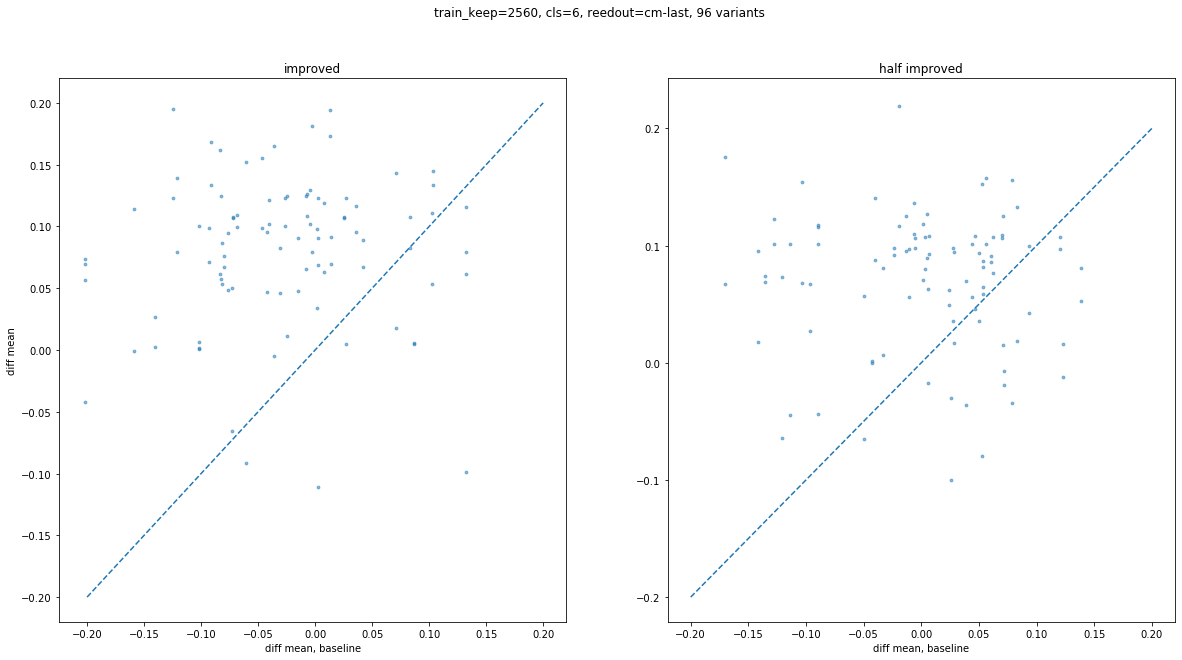

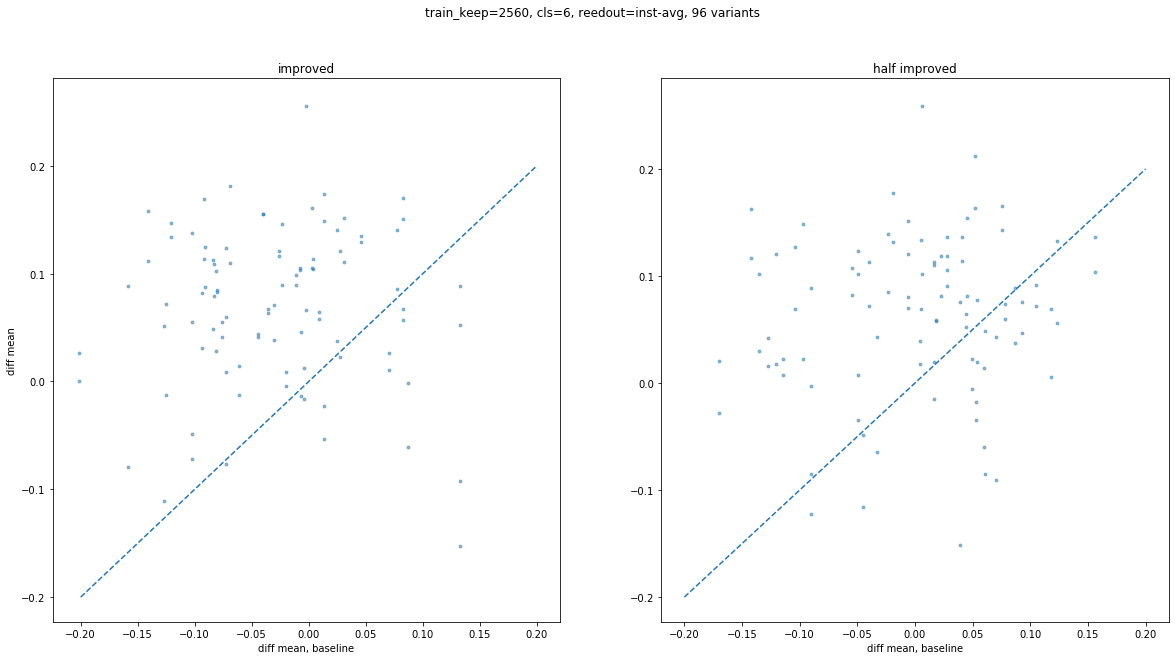

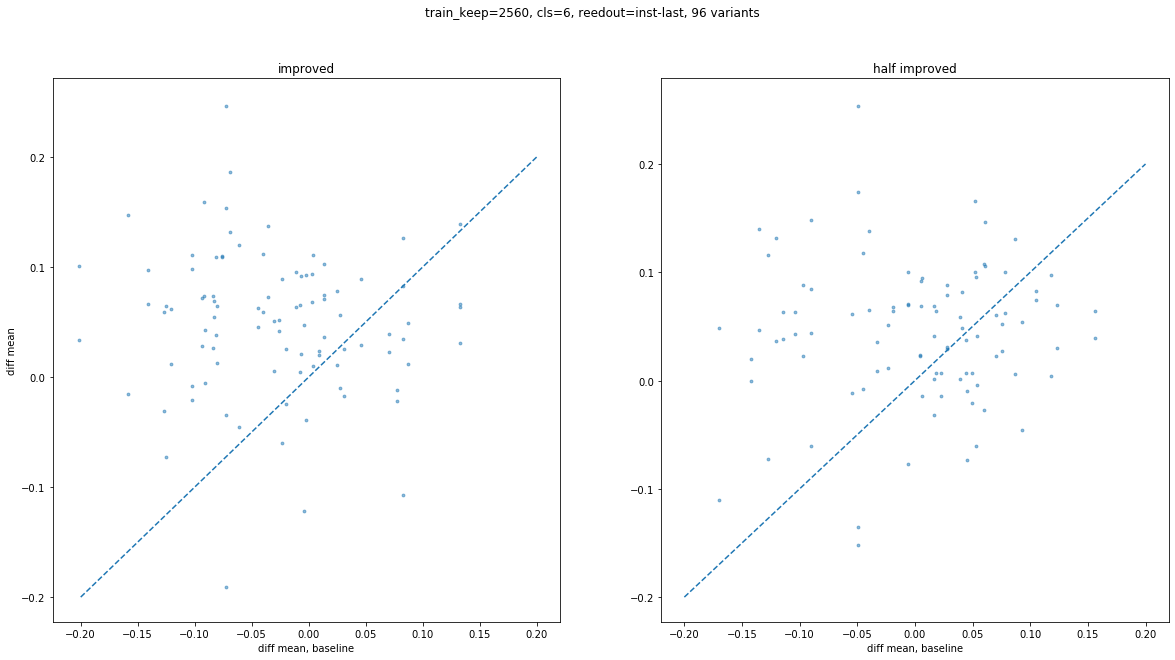

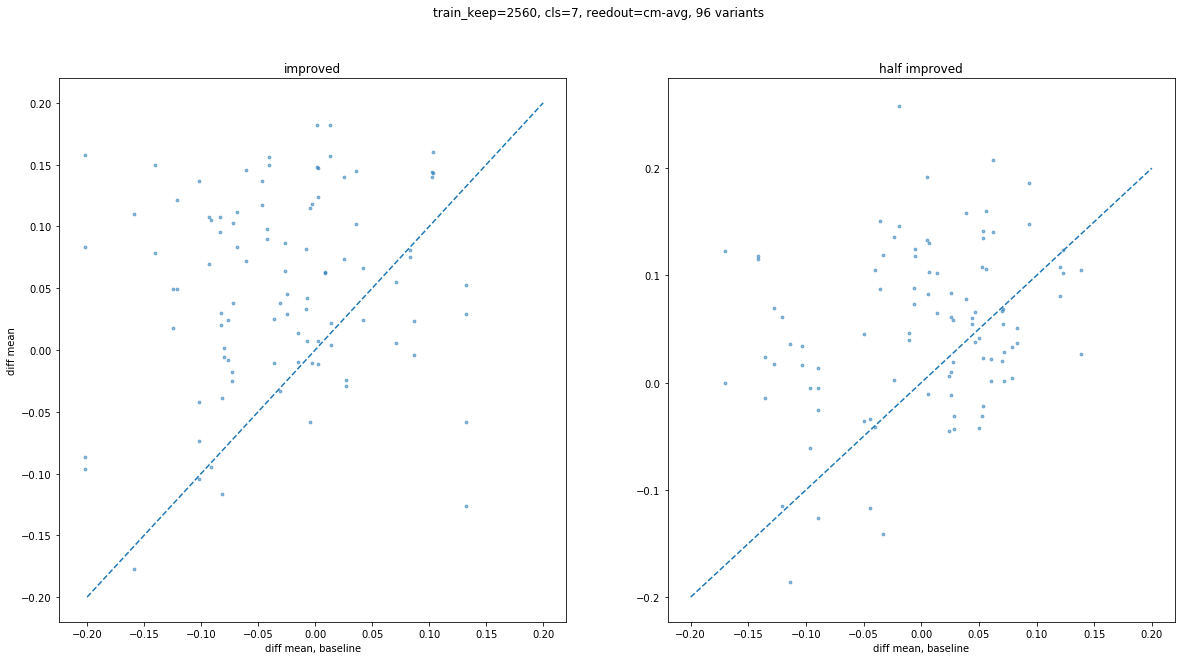

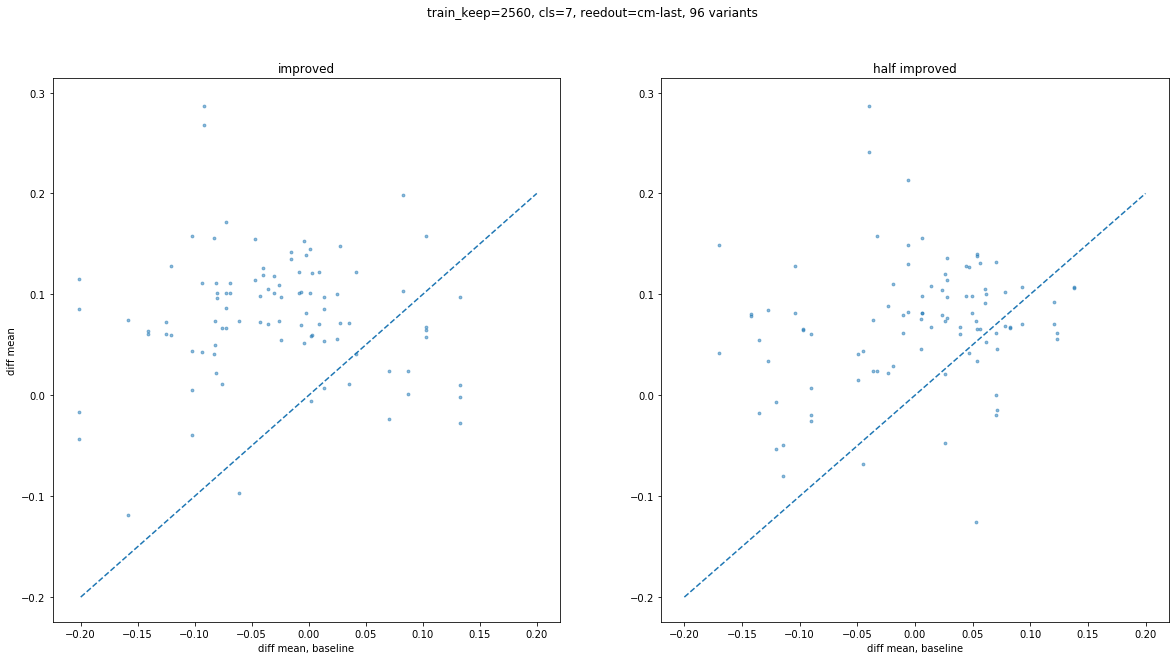

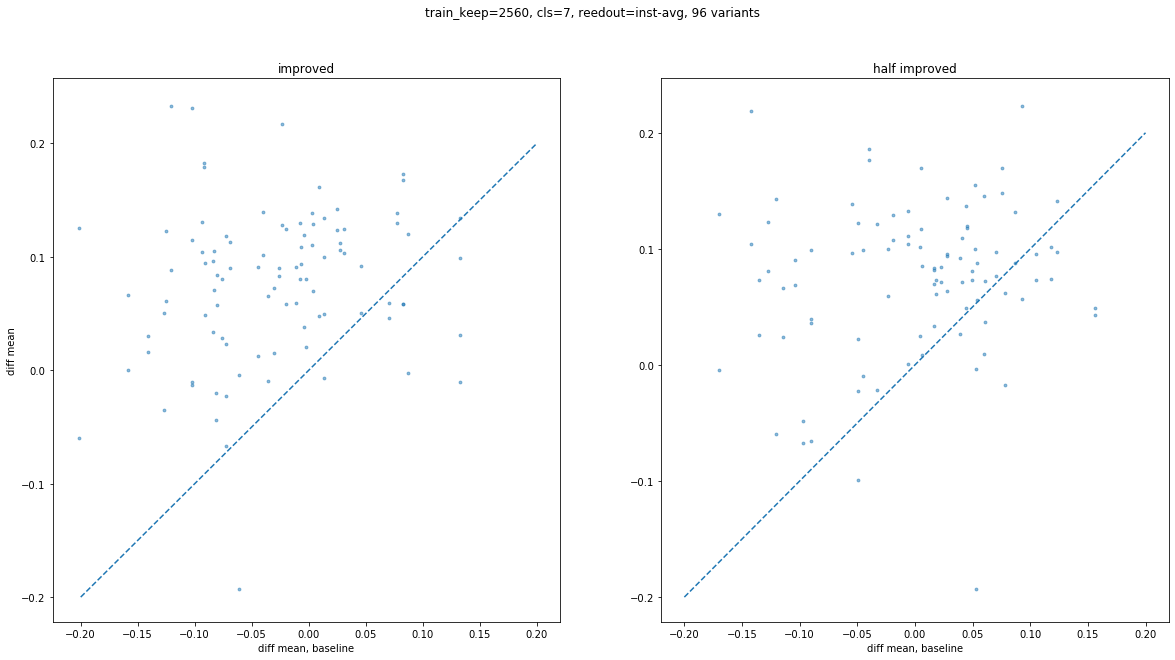

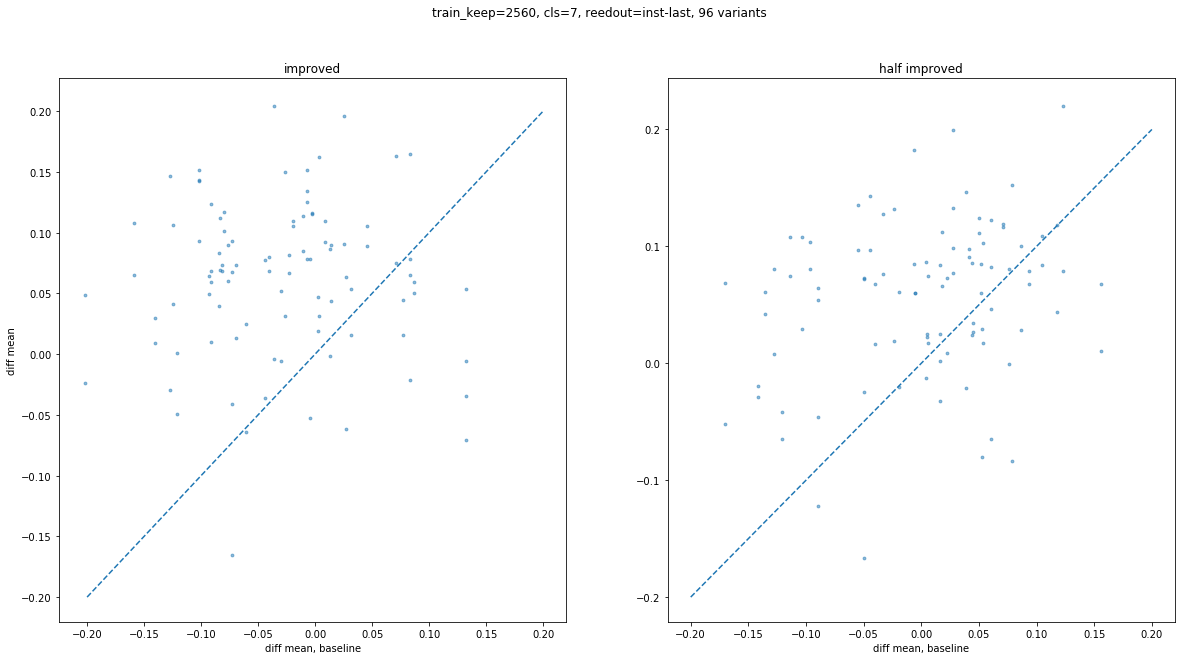

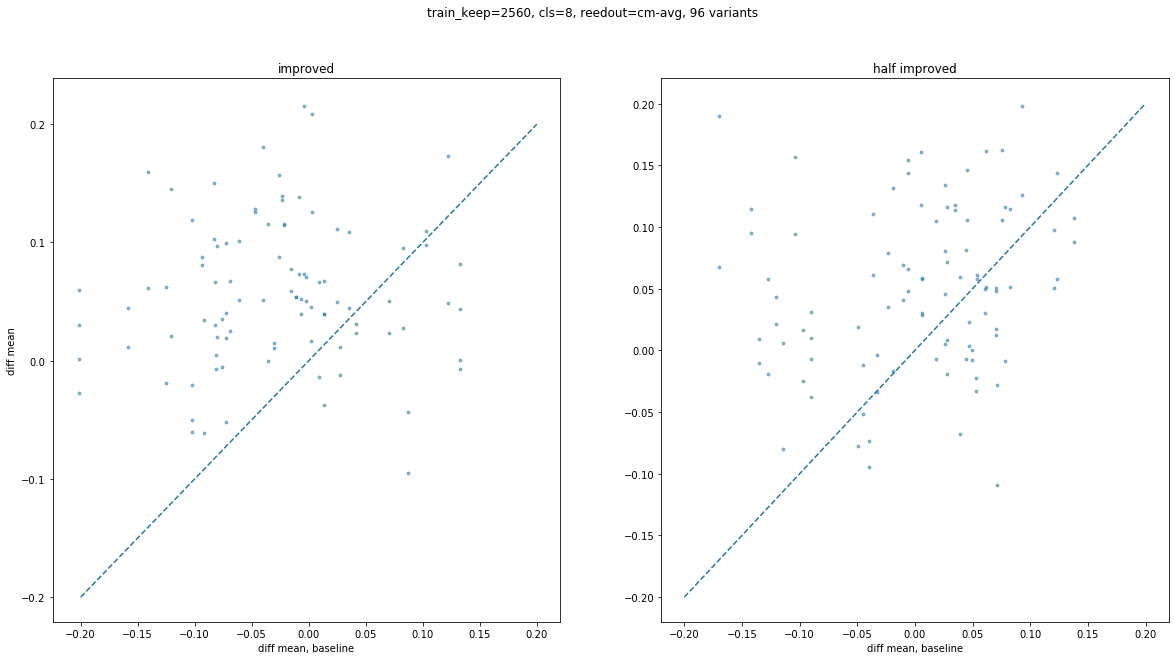

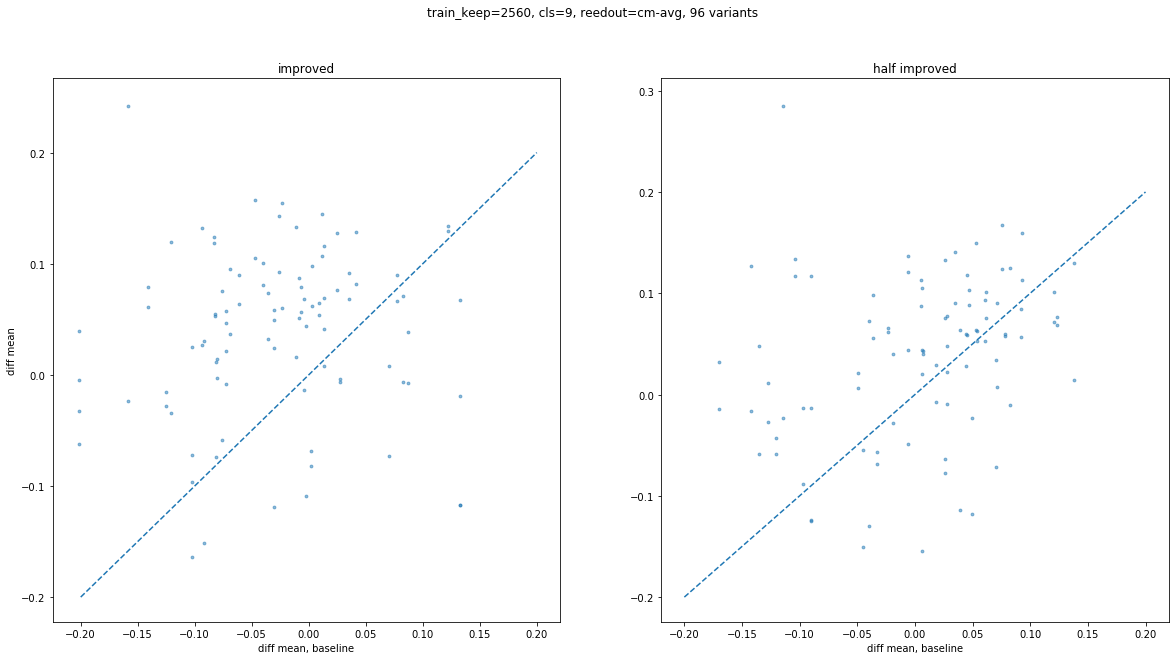

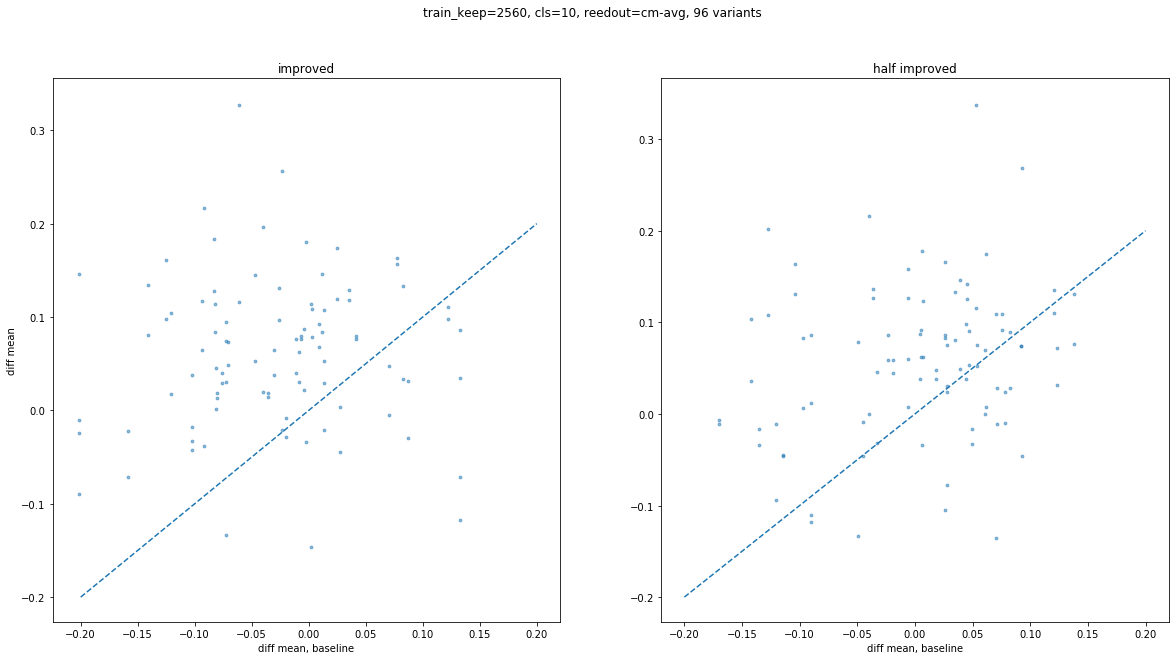

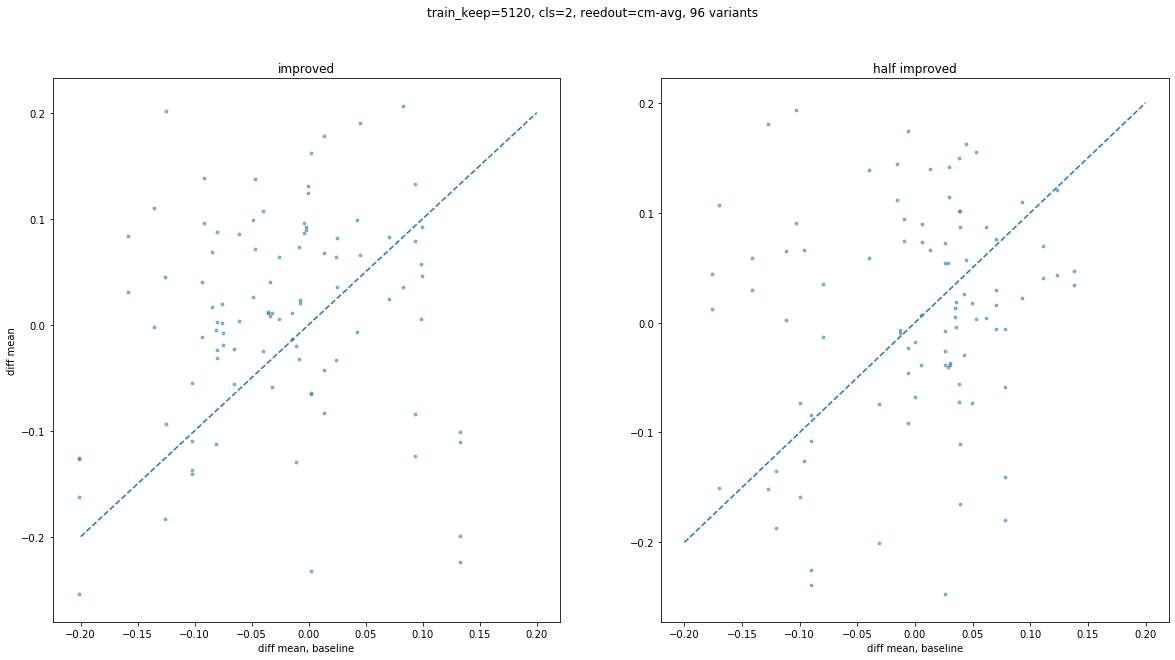

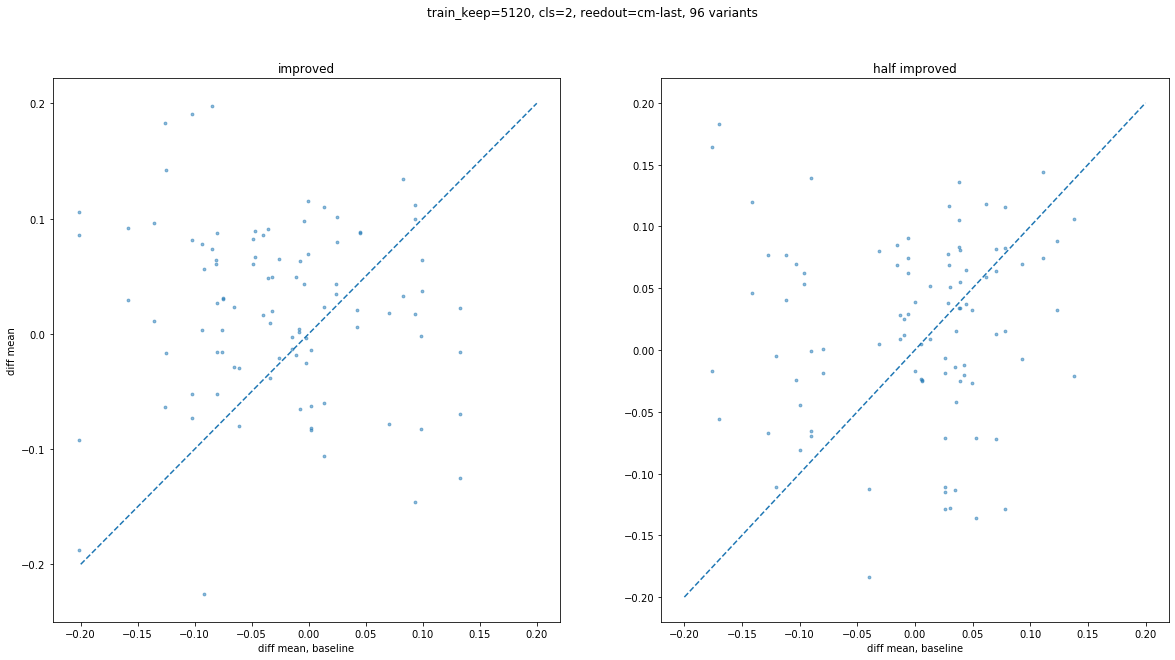

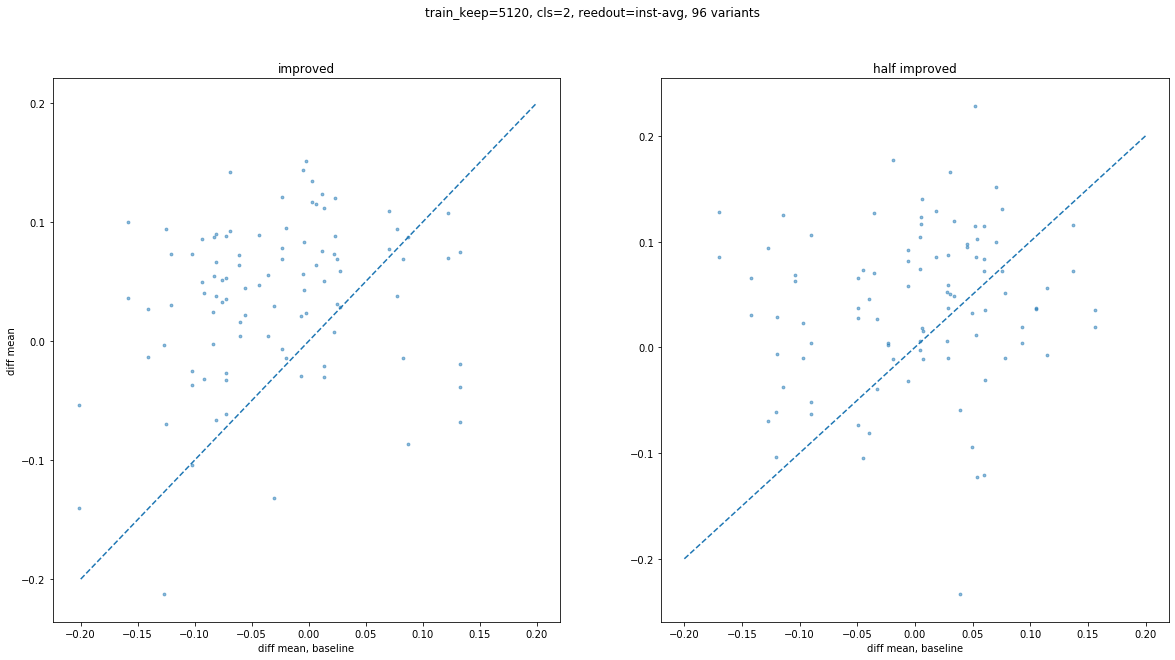

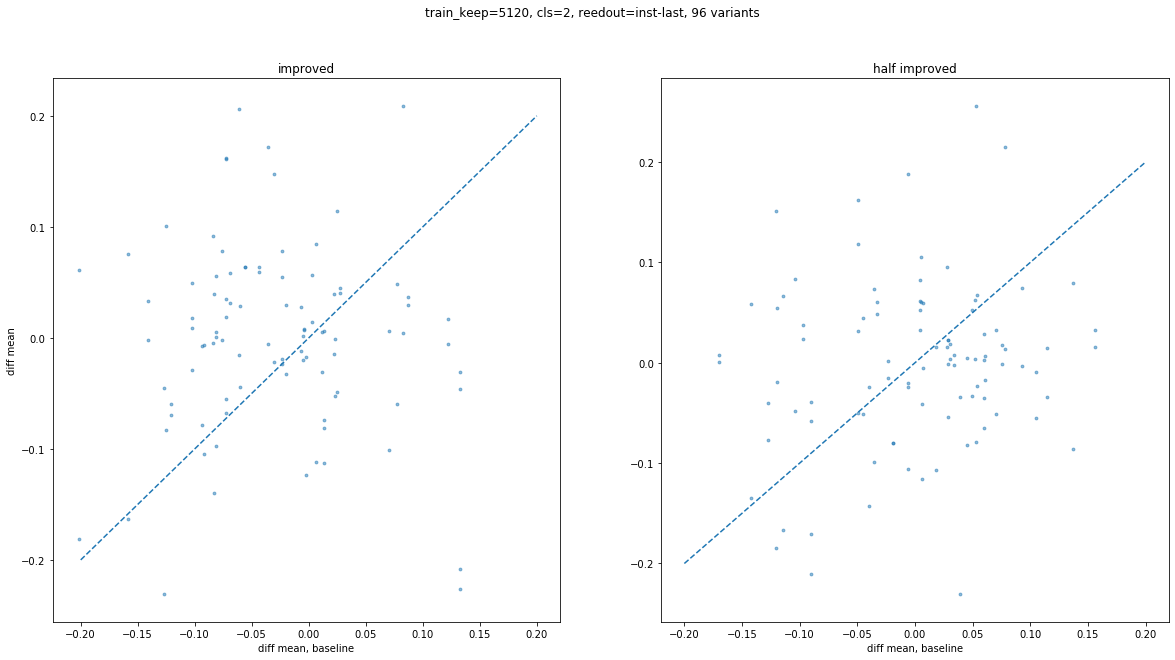

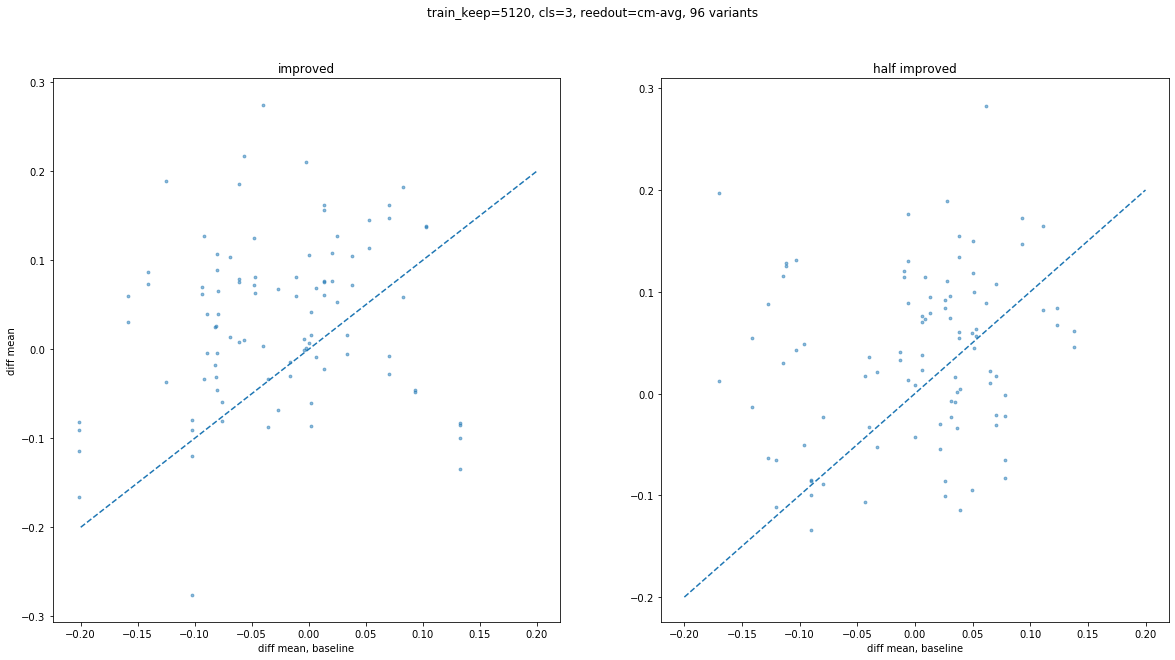

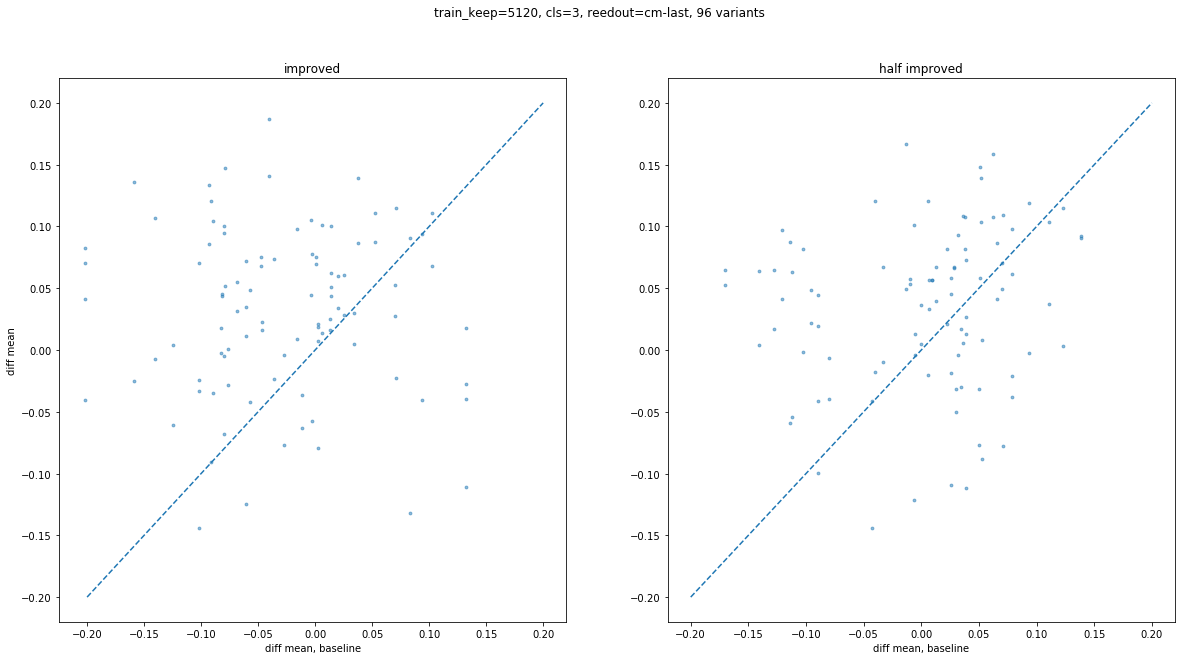

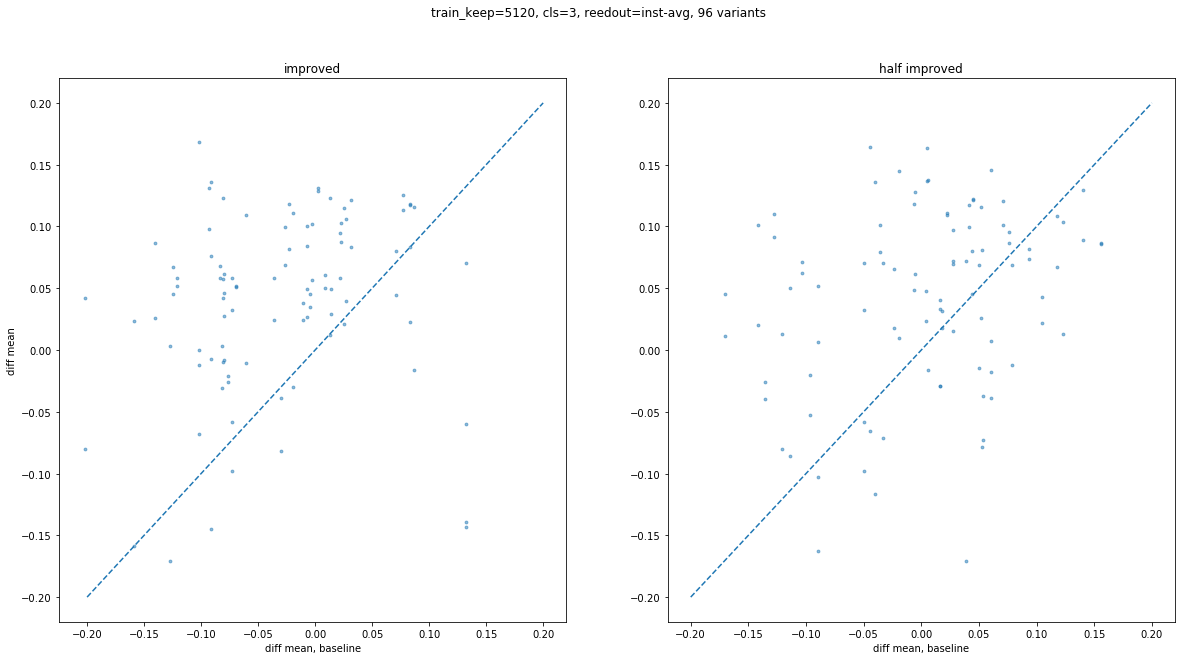

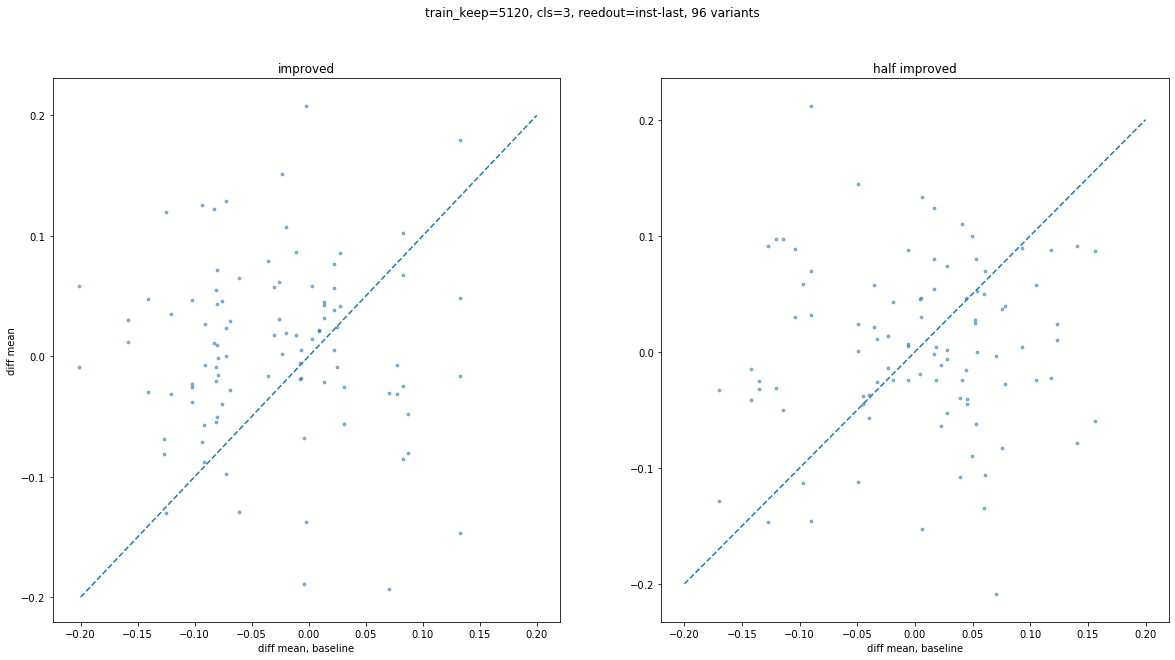

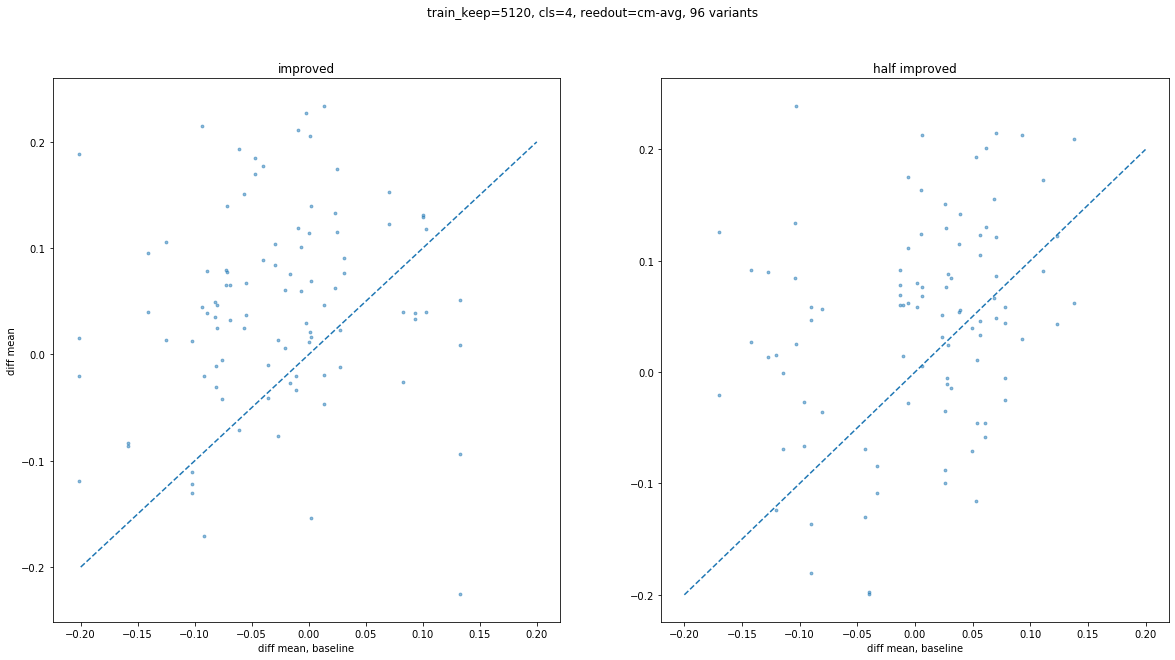

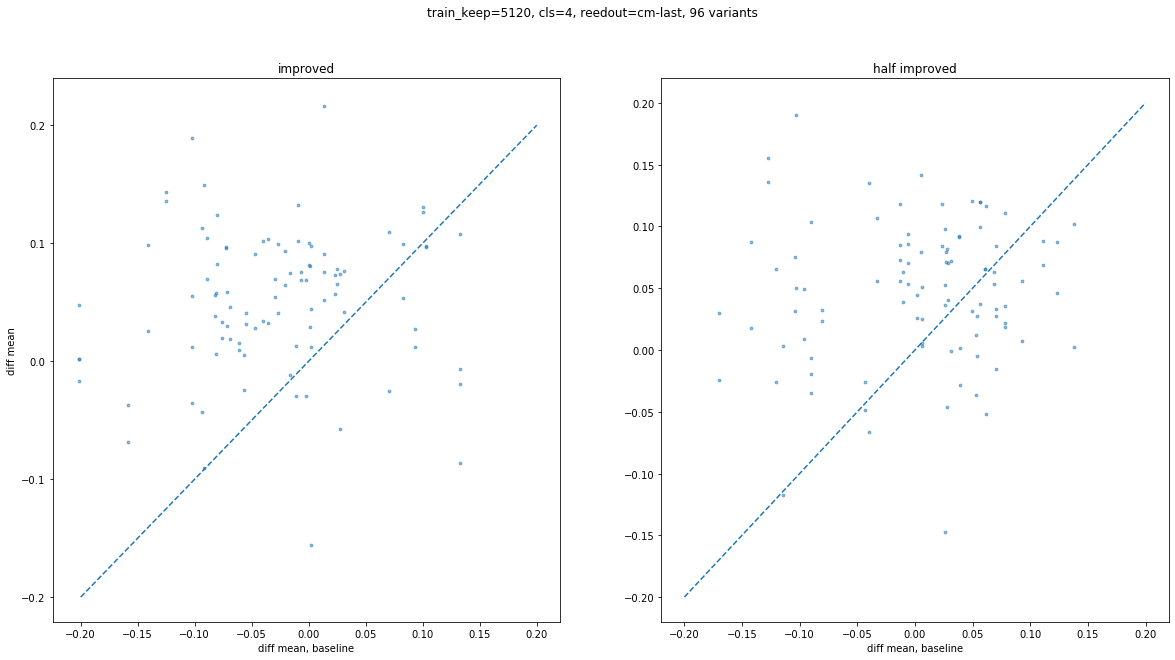

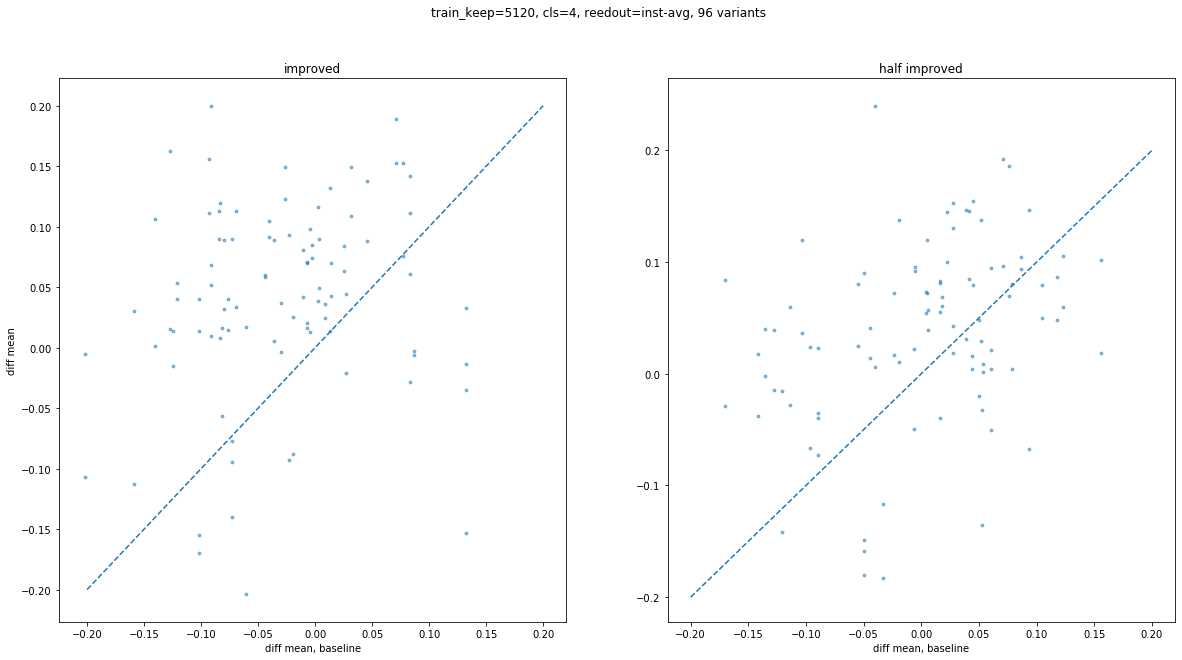

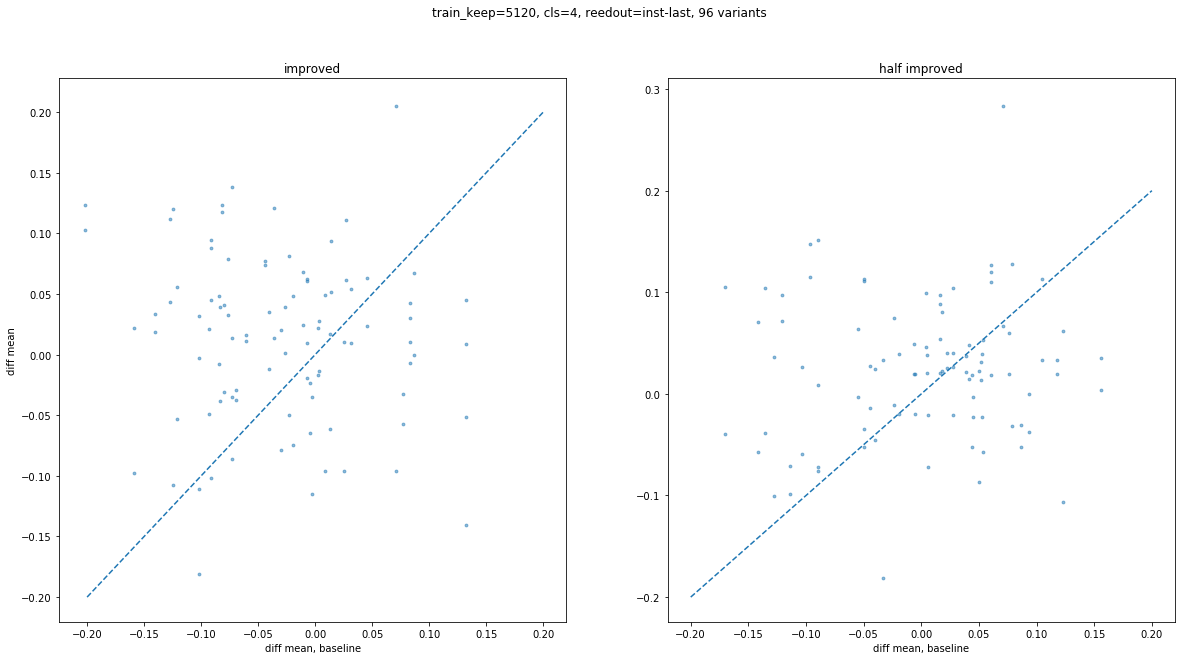

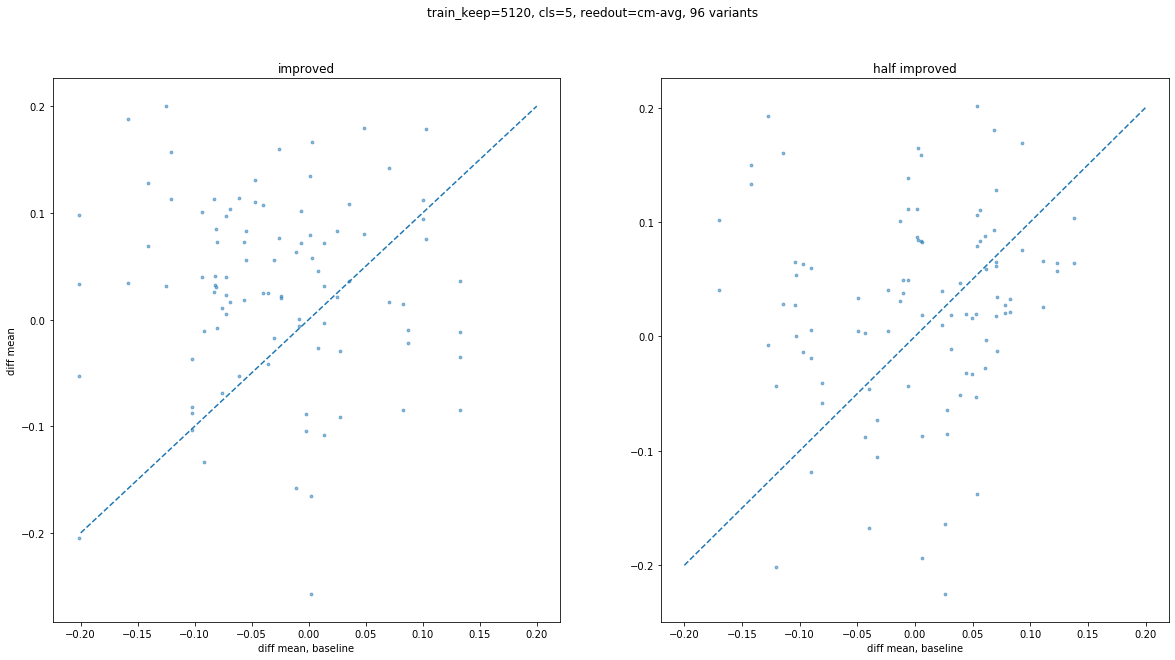

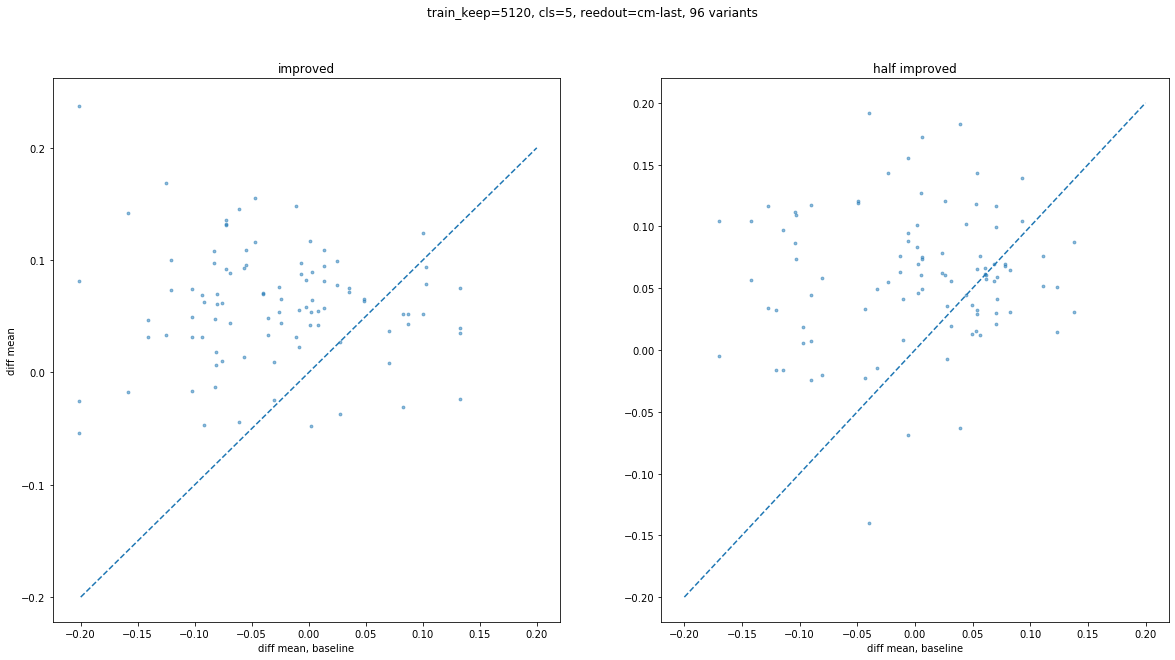

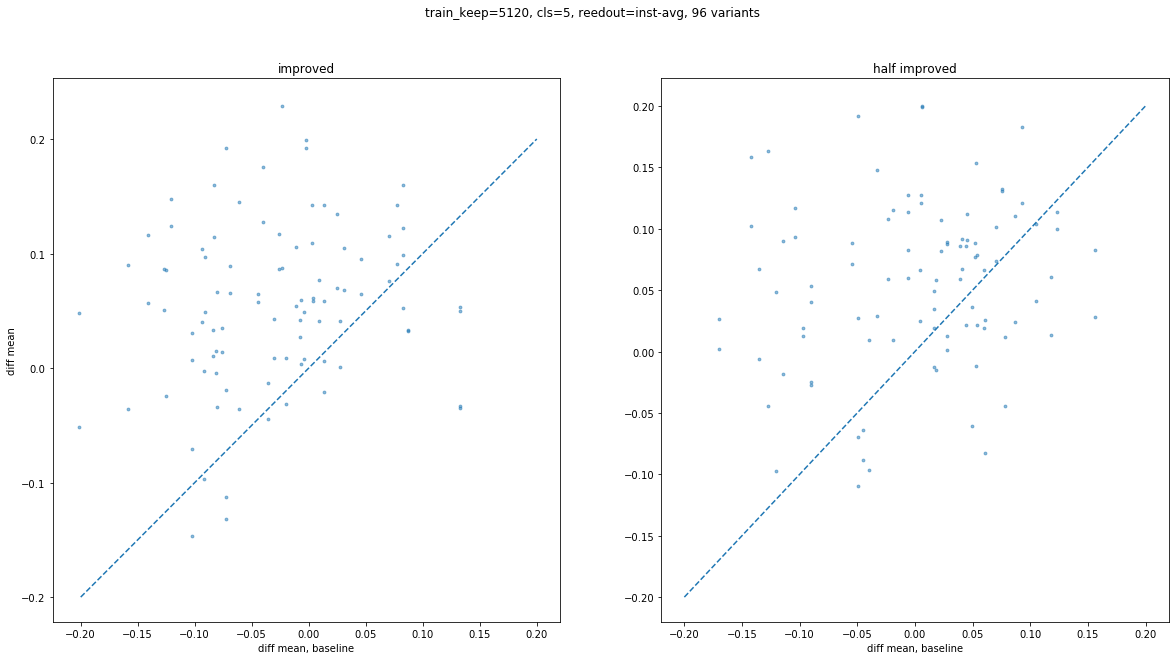

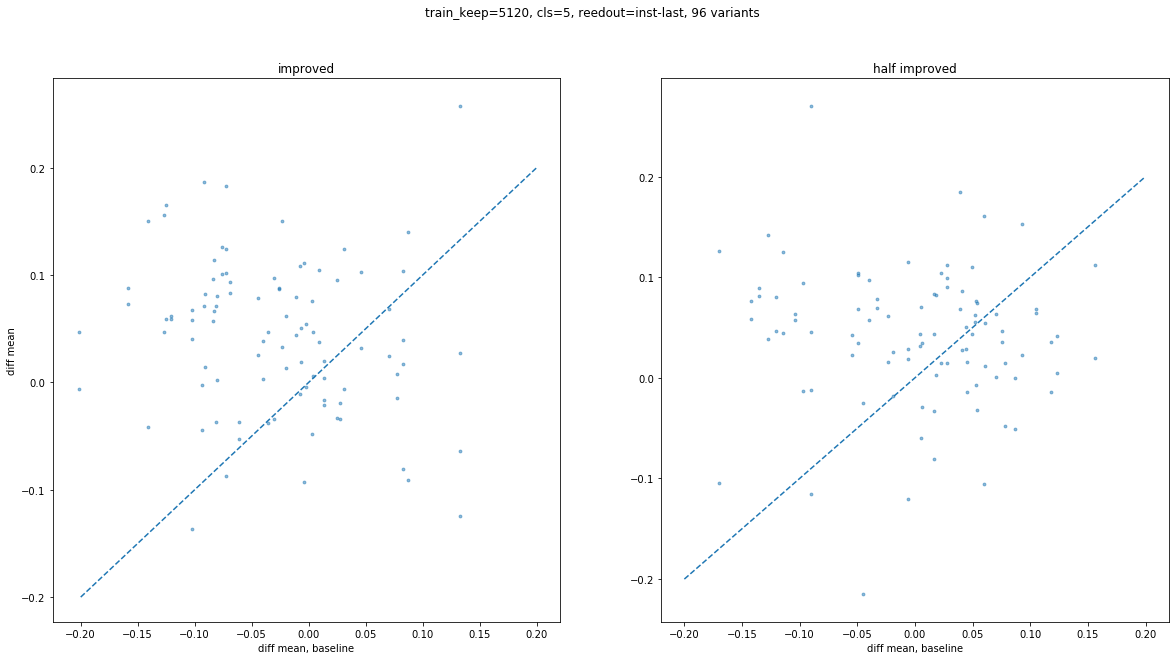

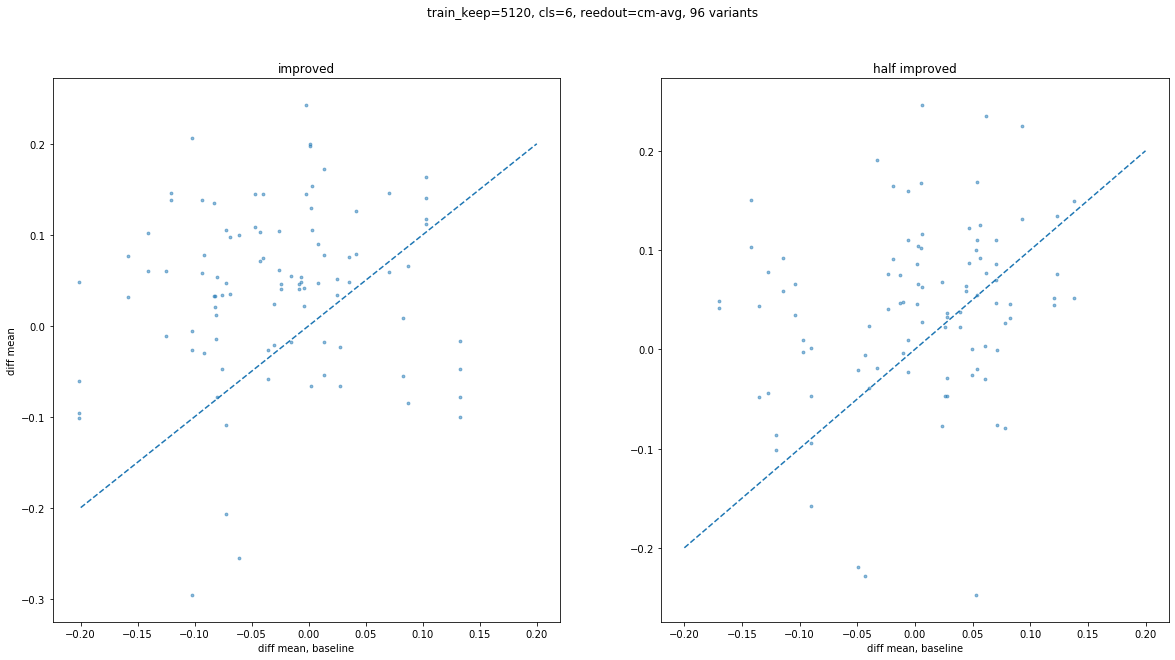

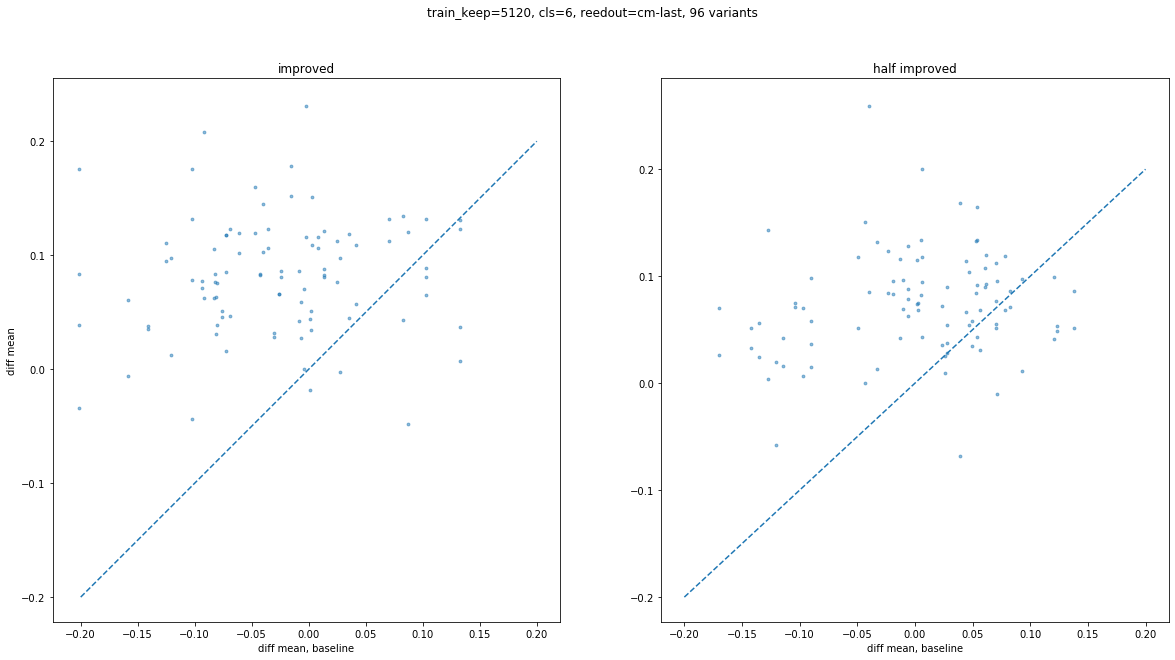

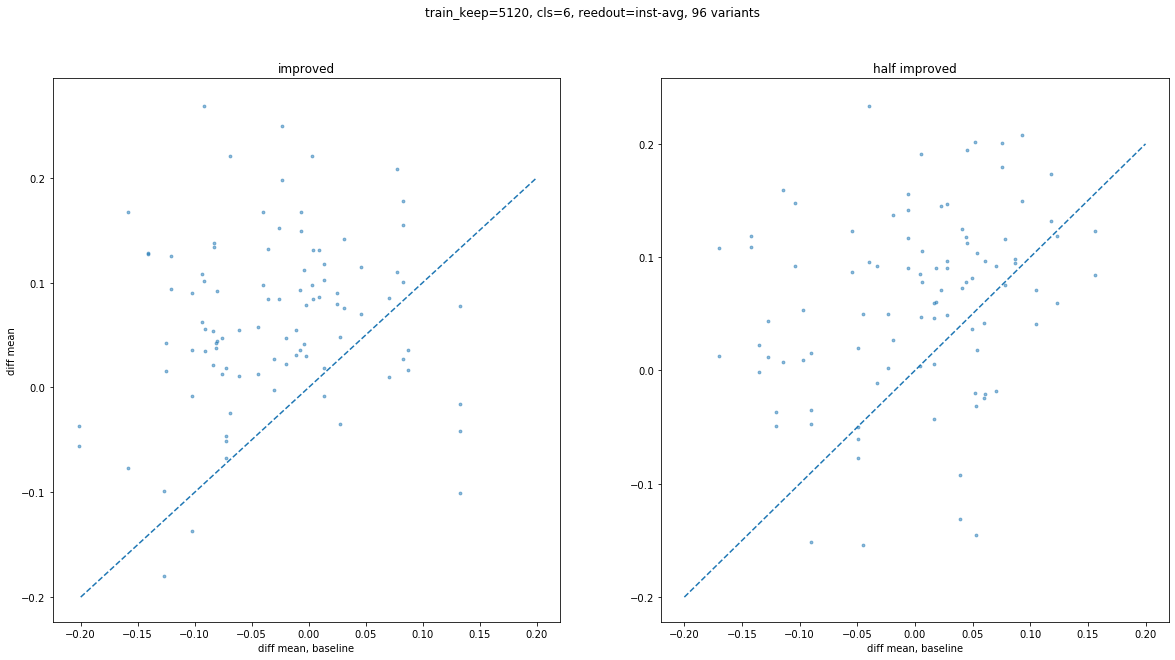

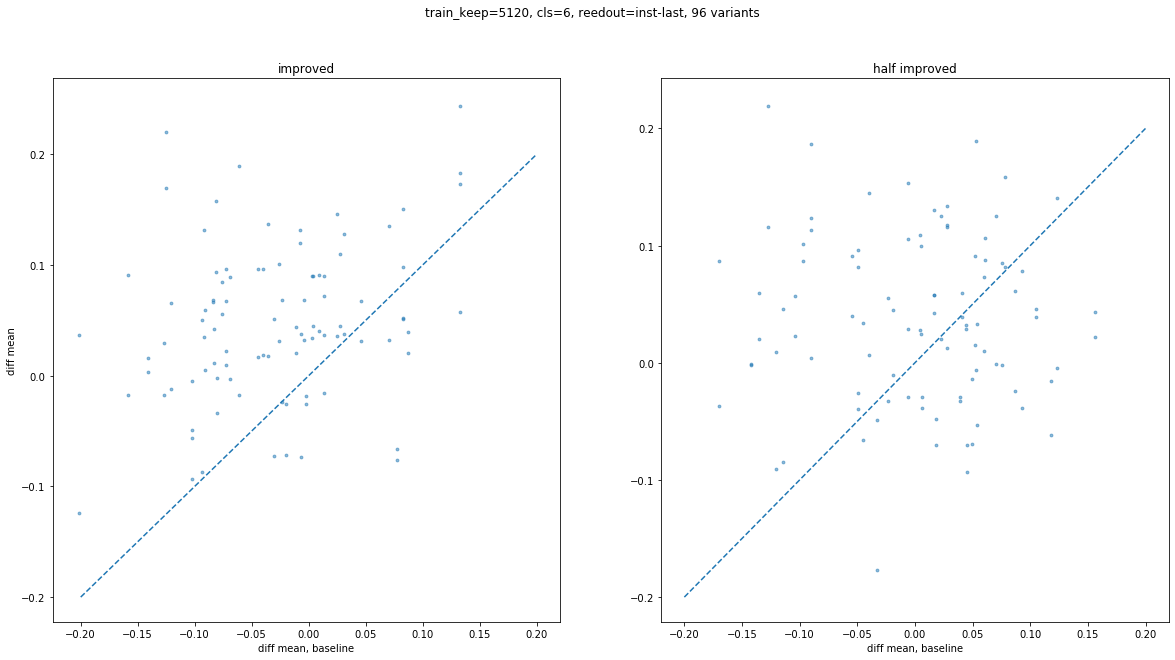

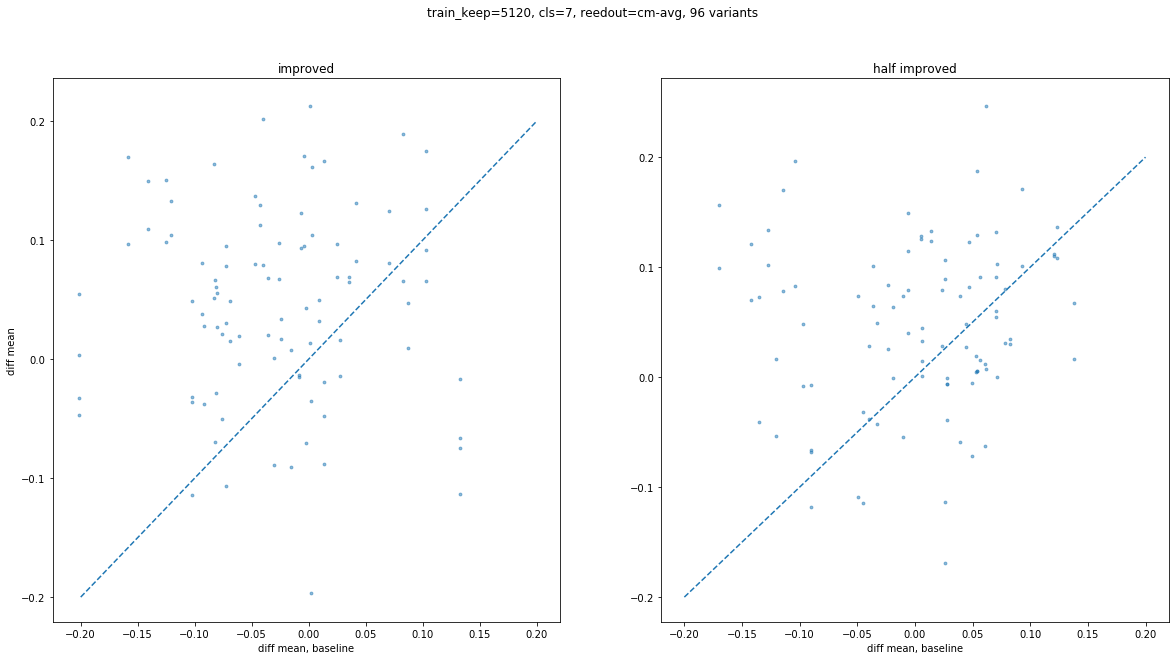

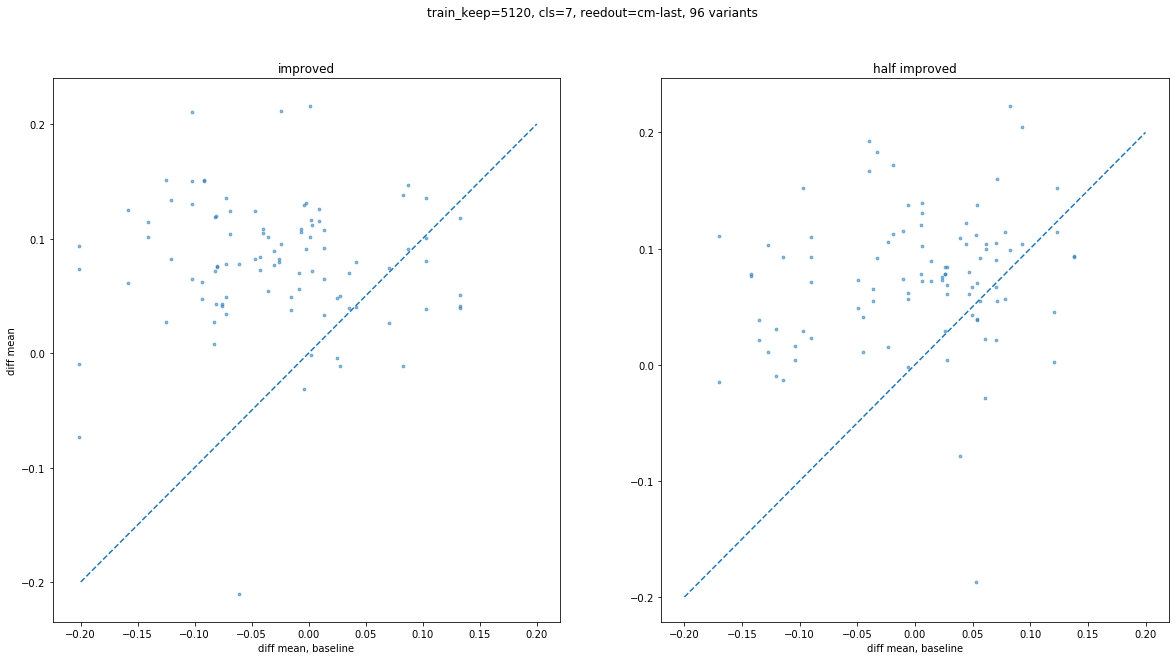

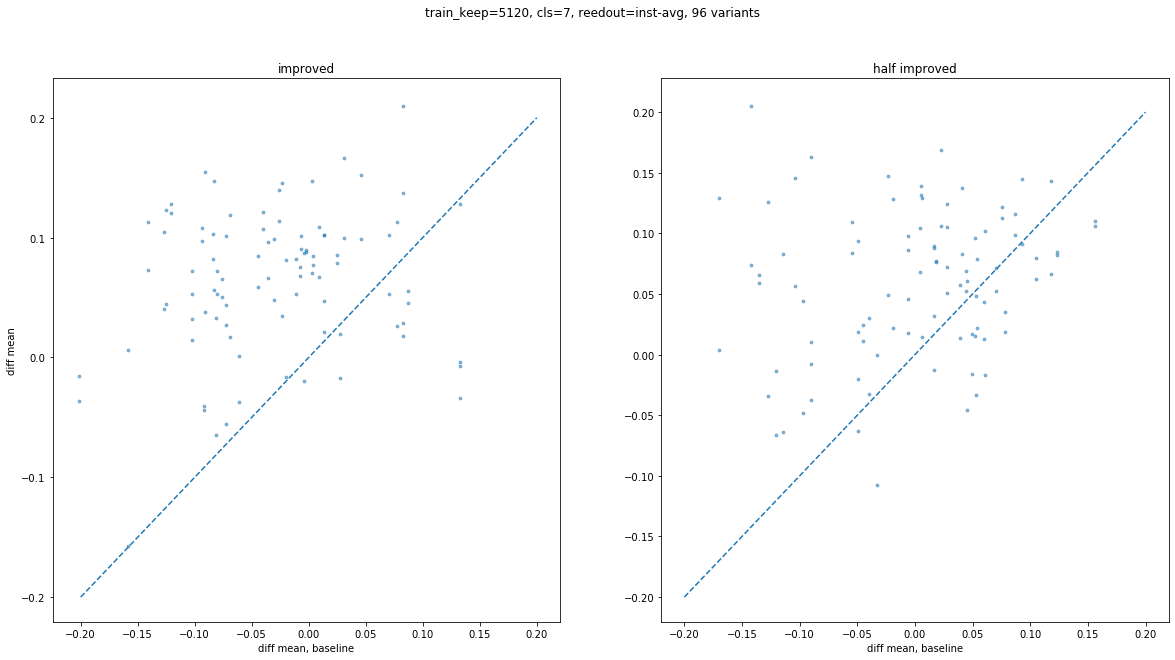

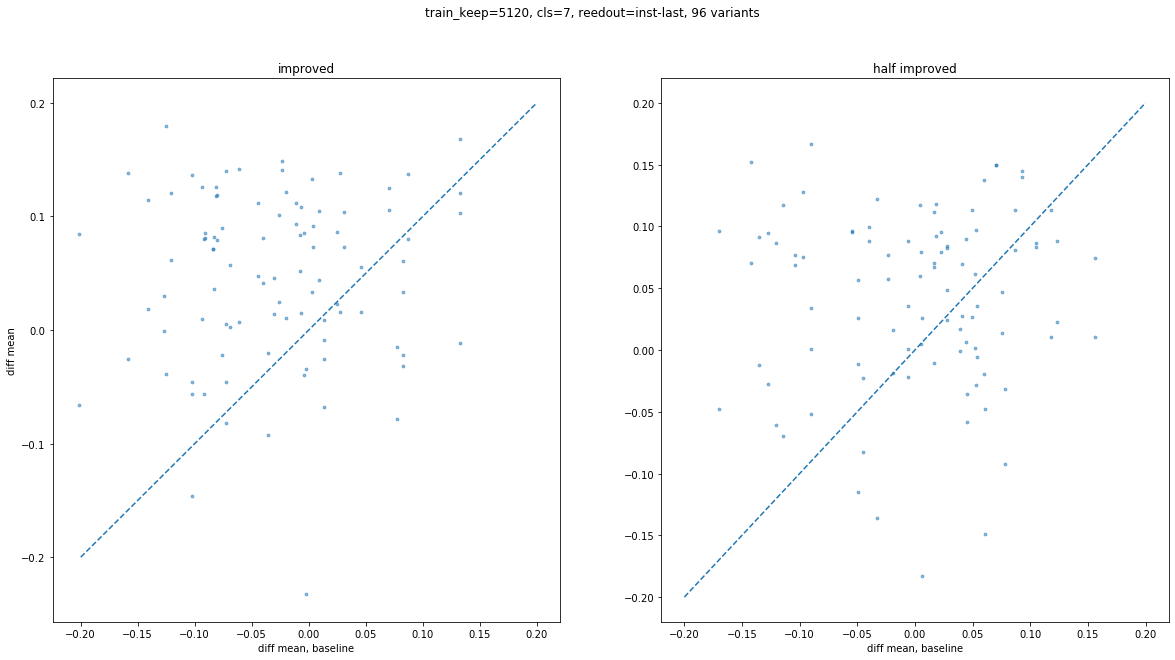

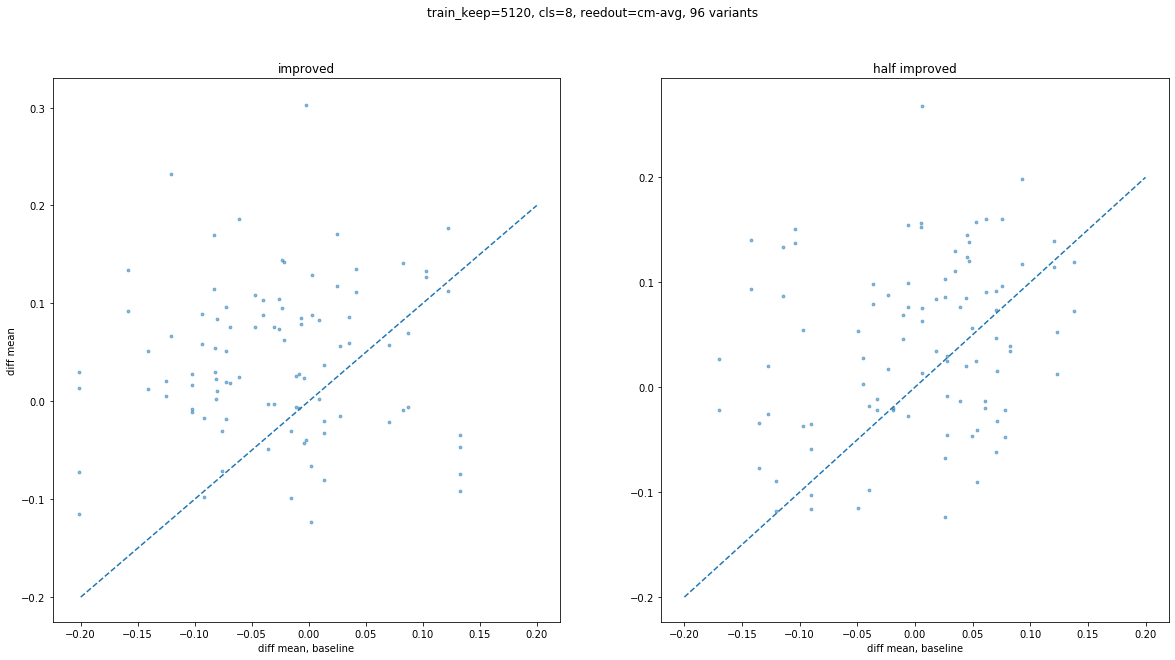

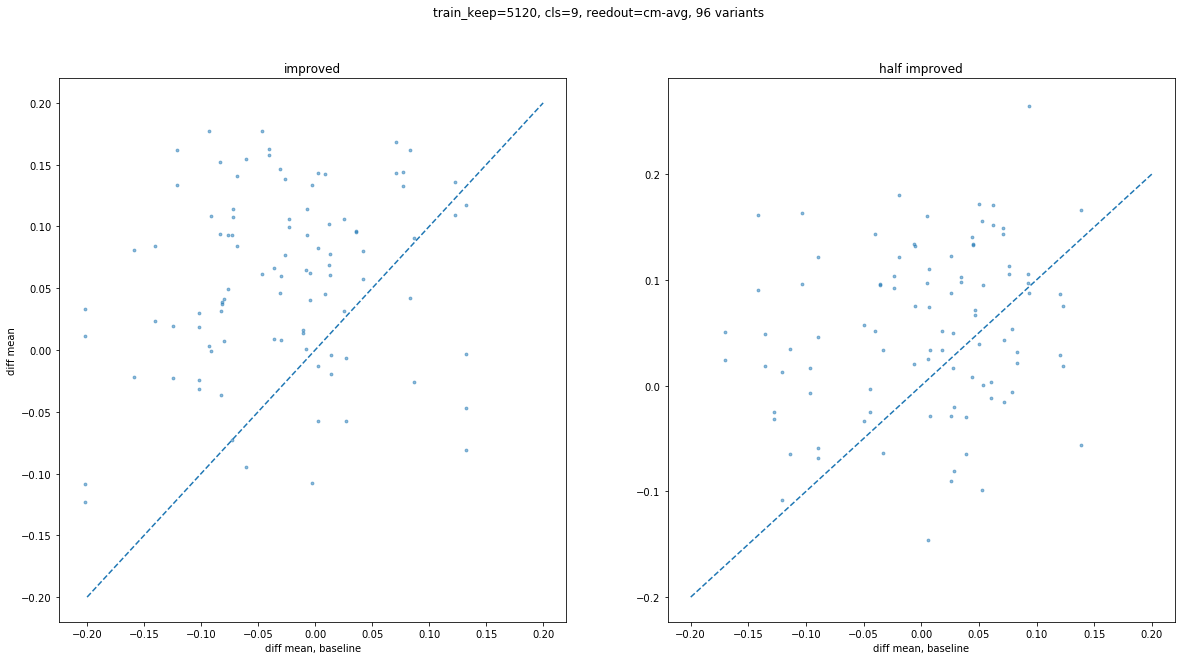

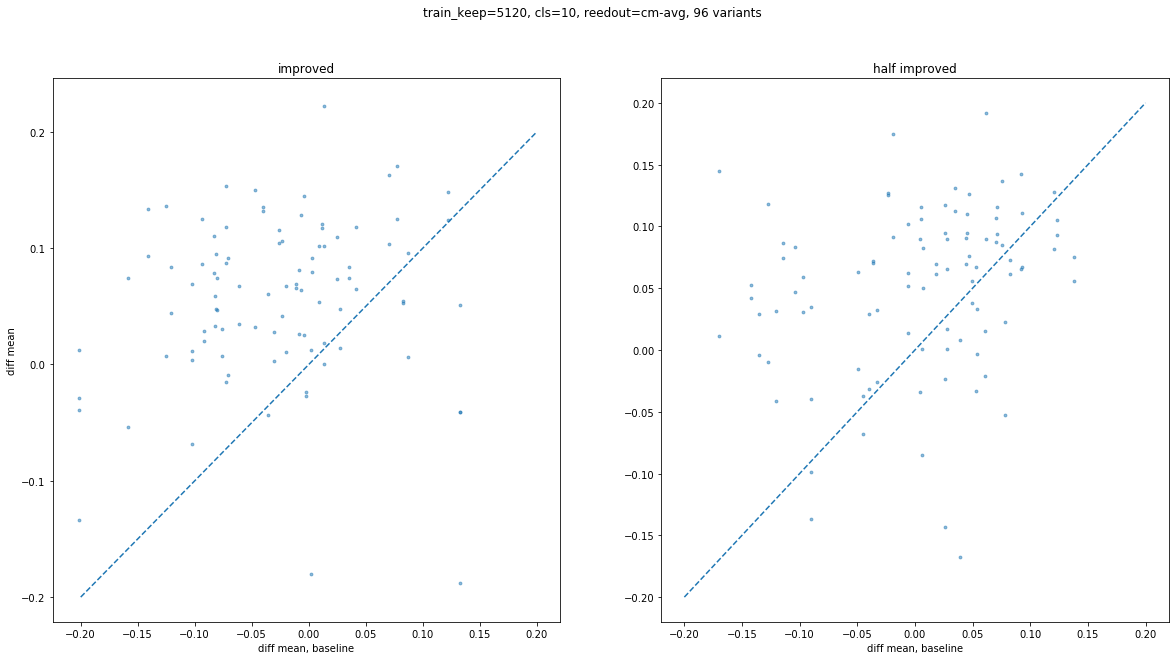

(7776, 2)
(7776, 2)


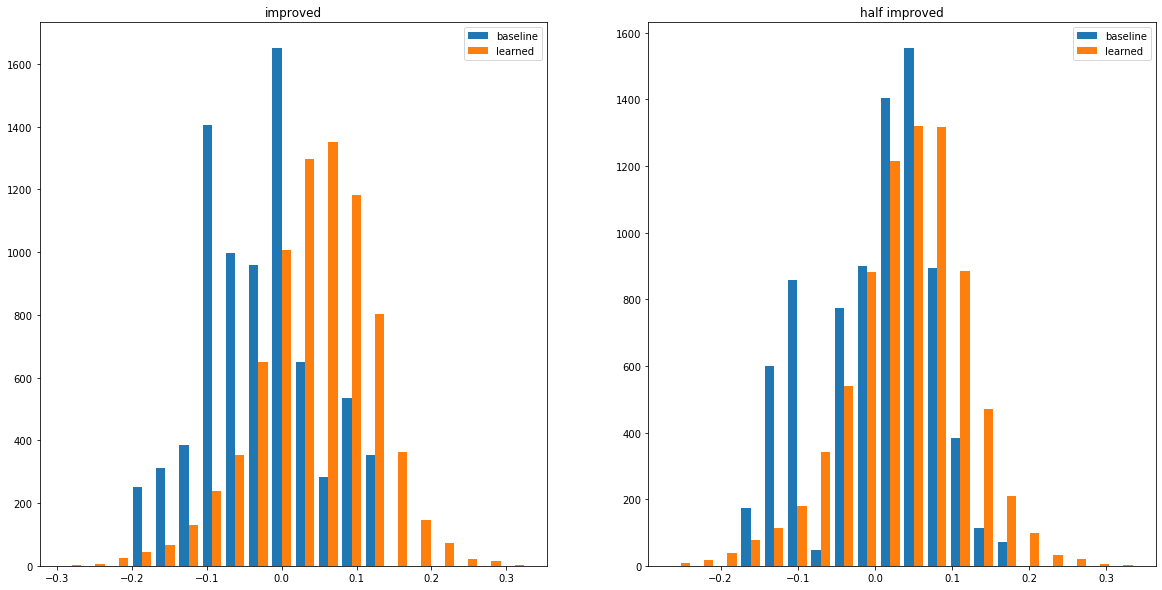

In [9]:
def show_scatter_plots():
    diff_mean_half_improved_all = []
    diff_mean_half_improved_all_baseline = []
    diff_mean_improved_all = []
    diff_mean_improved_all_baseline = []
    for train_keep in df_main_result.index.get_level_values('train_keep').unique():
        df_main_result_this_train = df_main_result.xs(train_keep, level='train_keep')
        for cls in df_main_result_this_train.index.get_level_values('rcnn_bl_cls').unique():
            if cls == 1:
                continue

            df_this_main = df_main_result_this_train.xs(cls, level='rcnn_bl_cls')

            for readout_type in df_this_main.index.get_level_values('readout_type').unique():
                df_this_readout = df_this_main.xs(readout_type, level='readout_type')
                plt.close('all')
                fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
                axes = axes.ravel()

                axes[0].scatter(
                    df_this_readout['hal_tuning_improved_baseline_mean'].values,
                    df_this_readout['hal_tuning_improved_mean'].values,
                    alpha=0.5,
                    s=8
                )
                axes[0].plot([-0.2, 0.2], [-0.2, 0.2], linestyle='--')
                axes[1].scatter(
                    df_this_readout['hal_tuning_half_improved_baseline_mean'].values,
                    df_this_readout['hal_tuning_half_improved_mean'].values,
                    alpha=0.5,
                    s=8
                )
                axes[1].plot([-0.2, 0.2], [-0.2, 0.2], linestyle='--')
                
                diff_mean_improved_all.extend(
                    df_this_readout['hal_tuning_improved_mean'].values.tolist()
                )
                diff_mean_improved_all_baseline.extend(
                    df_this_readout['hal_tuning_improved_baseline_mean'].values.tolist(),
                )
                diff_mean_half_improved_all.extend(
                    df_this_readout['hal_tuning_half_improved_mean'].values.tolist()
                )
                diff_mean_half_improved_all_baseline.extend(
                    df_this_readout['hal_tuning_half_improved_baseline_mean'].values.tolist(),
                )

                fig.suptitle(f'train_keep={train_keep}, cls={cls}, reedout={readout_type}, {len(df_this_readout)} variants')
                axes[0].set_title('improved')
                axes[1].set_title('half improved')

                axes[0].set_xlabel('diff mean, baseline')
                axes[1].set_xlabel('diff mean, baseline')
                axes[0].set_ylabel('diff mean')
                plt.show()
    # plot a final one
    plt.close('all')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    data_all = np.asarray([diff_mean_improved_all_baseline, diff_mean_improved_all]).T
    print(data_all.shape)
    axes[0].hist(data_all, label=['baseline', 'learned'], bins=20)
    axes[0].legend()
    axes[0].set_title('improved')
    
    data_all = np.asarray([diff_mean_half_improved_all_baseline, diff_mean_half_improved_all]).T
    print(data_all.shape)
    axes[1].hist(data_all, label=['baseline', 'learned'], bins=20)
    axes[1].legend()
    axes[1].set_title('half improved')
    
    
    plt.show()
show_scatter_plots()